In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")


In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
%%time
train = pd.read_csv('/content/drive/My Drive/PUBG Data/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('/content/drive/My Drive/PUBG Data/test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)
CPU times: user 19.4 s, sys: 2.02 s, total: 21.4 s
Wall time: 30.9 s


In [ ]:
train.shape

(4446966, 29)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

In [ ]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


Exploratory Data Analysis (EDA)


In [ ]:
#unique count for id
for i in ['Id','groupId','matchId']:
    print(f'unique [{i}] count:', train[i].nunique())

unique [Id] count: 4446966
unique [groupId] count: 2026745
unique [matchId] count: 47965


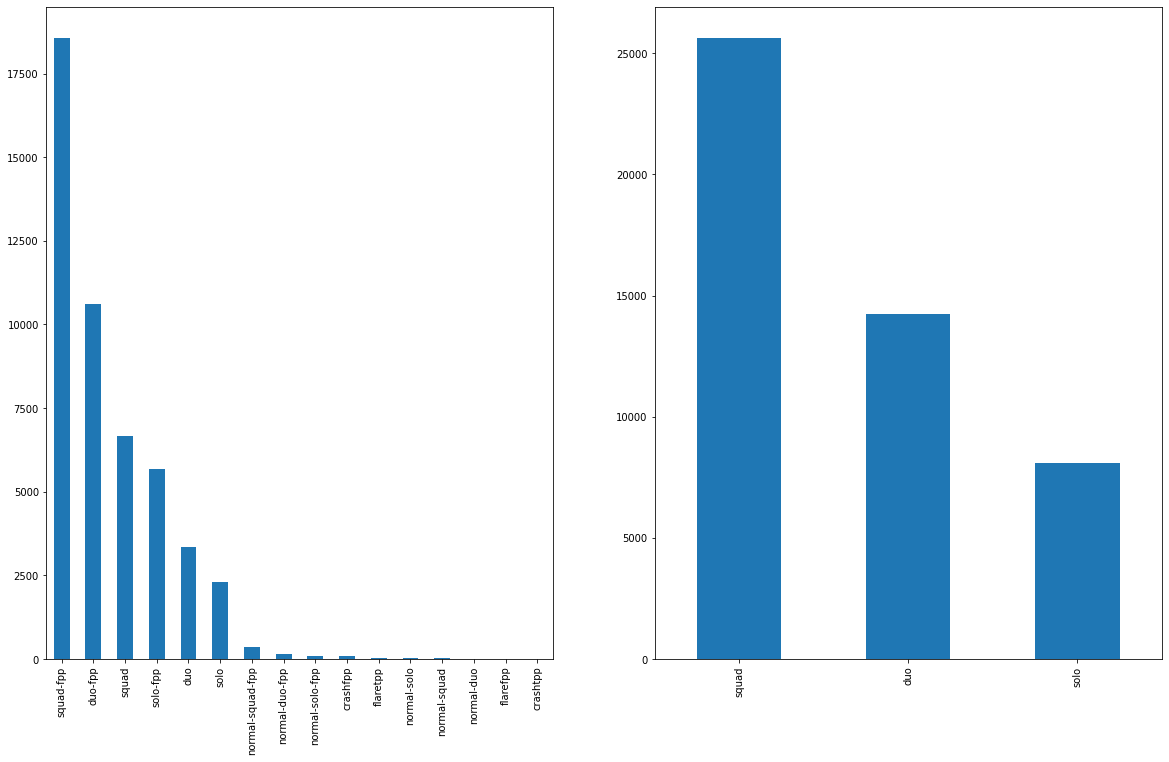

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

In [ ]:
def mergeList(list1,list2):
    return list(itertools.product(list1,list2))
match = train.groupby(['matchType','matchId']).size().to_frame('players in match')
group = train.groupby(['matchType','matchId','groupId']).size().to_frame('players in group')
pd.concat([match.groupby('matchType').describe()[mergeList(['players in match'],['min','mean','max'])], 
           group.groupby('matchType').describe()[mergeList(['players in group'],['min','mean','max'])]], axis=1)

players in match                   players in group                
                       min       mean    max              min      mean   max
matchType                                                                    
duo                    7.0  92.985658  100.0              1.0  2.050456  72.0
solo                   1.0  89.031872  100.0              1.0  1.039249  64.0
squad                  5.0  93.723193  100.0              1.0  3.492575  74.0

In [ ]:
print(group['players in group'].nlargest(5)) 

matchType  matchId         groupId       
squad      b30f3d87189aa6  14d6b54cdec6bc    74
duo        3e029737889ce9  b8275198faa03b    72
solo       41a634f62f86b7  128b07271aa012    64
duo        7e93ce71ac6f61  7385e5fe214021    49
squad      3c2531adf5b942  e52a2e6ca30474    36
Name: players in group, dtype: int64


In [ ]:
subset = train[train['matchId']=='3e029737889ce9']
sub_grp = subset[subset['groupId']=='b8275198faa03b']

print('matchId ==\'3e029737889ce9\' & groupId ==\'b8275198faa03b\'')
print('-'*50)
print('players:',len(subset))
print('groups:',subset['groupId'].nunique())
print('numGroups:',subset['numGroups'].unique())
print('maxPlace:',subset['maxPlace'].unique())
print('-'*50)
print('max-group players:',len(sub_grp))
print('max-group winPlacePerc:',sub_grp['winPlacePerc'].unique())
print('-'*50)
print('winPlacePerc:',subset['winPlacePerc'].sort_values().unique())

matchId =='3e029737889ce9' & groupId =='b8275198faa03b'
--------------------------------------------------
players: 99
groups: 14
numGroups: [14]
maxPlace: [50]
--------------------------------------------------
max-group players: 72
max-group winPlacePerc: [0.2449]
--------------------------------------------------
winPlacePerc: [0.     0.0204 0.0408 0.0612 0.0816 0.102  0.1224 0.1633 0.1837 0.2041
 0.2245 0.2449 0.5102 1.    ]


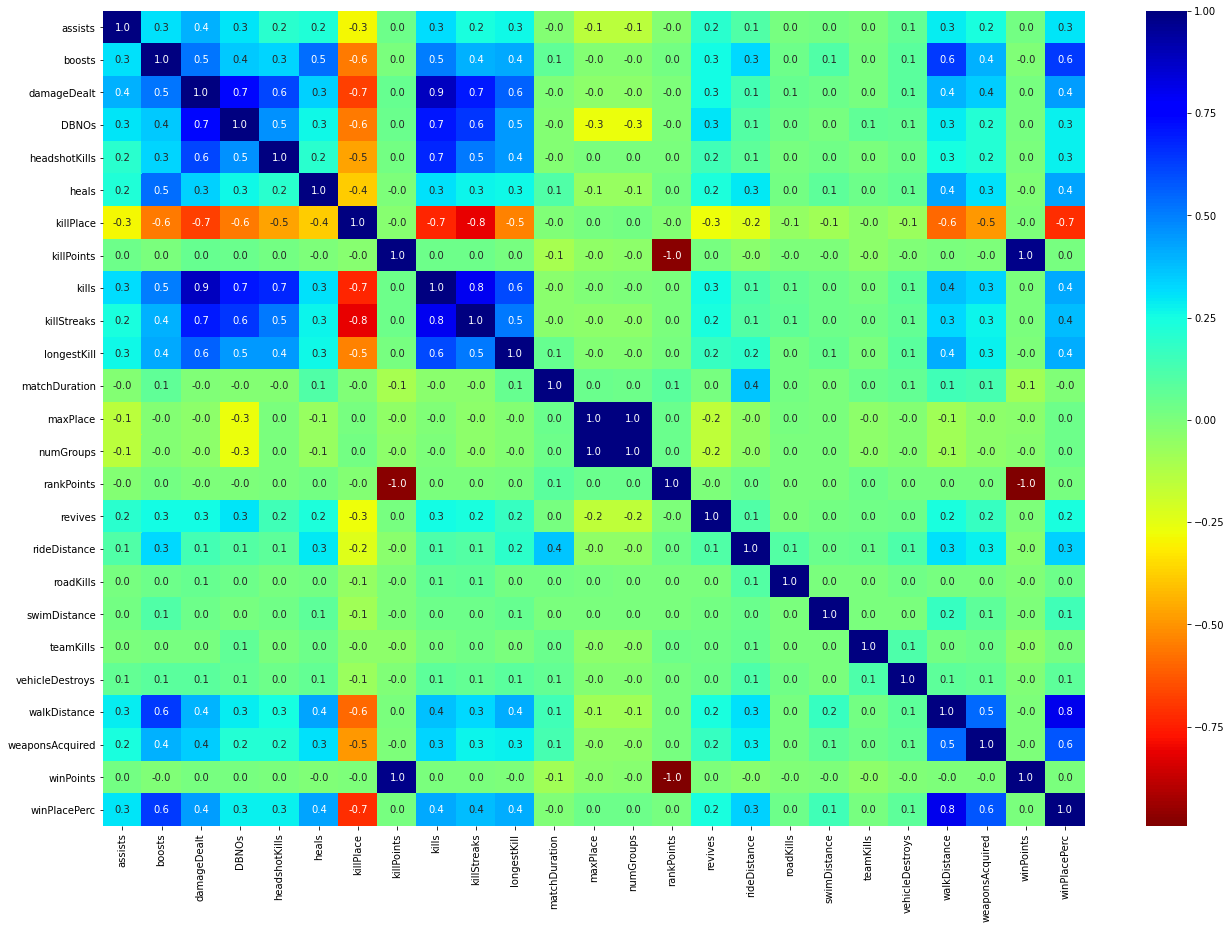

In [ ]:
corr = train.corr()
f,ax = plt.subplots(figsize=(22,15))
sns.heatmap(train.corr(), annot=True, fmt= '.1f',ax=ax, cmap="jet_r")
sns.set(font_scale=1.50)
plt.show()

Featured Engineering

In [ ]:
print("On an average a person kills {:.4f} players, 99% of people have {} kills or less, while the maximum kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

On an average a person kills 0.9248 players, 99% of people have 7.0 kills or less, while the maximum kills ever recorded is 72.


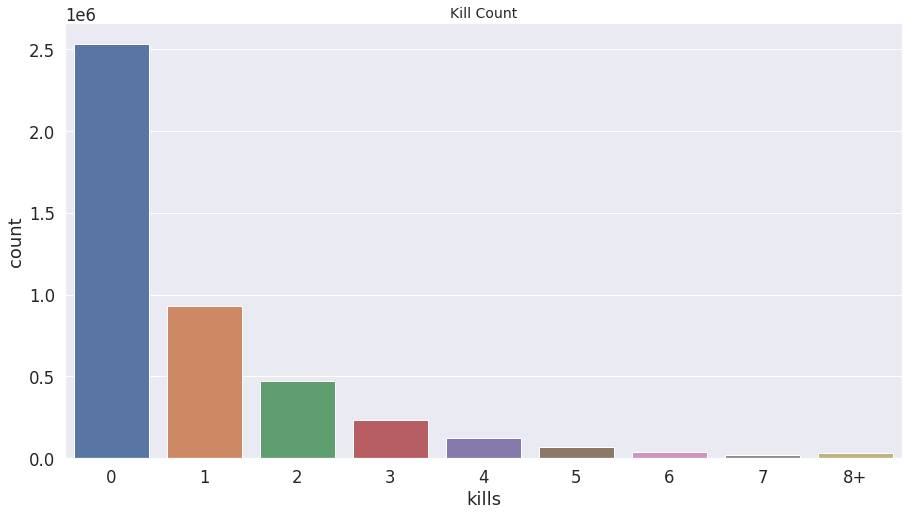

In [ ]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,8))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=14)
plt.show()

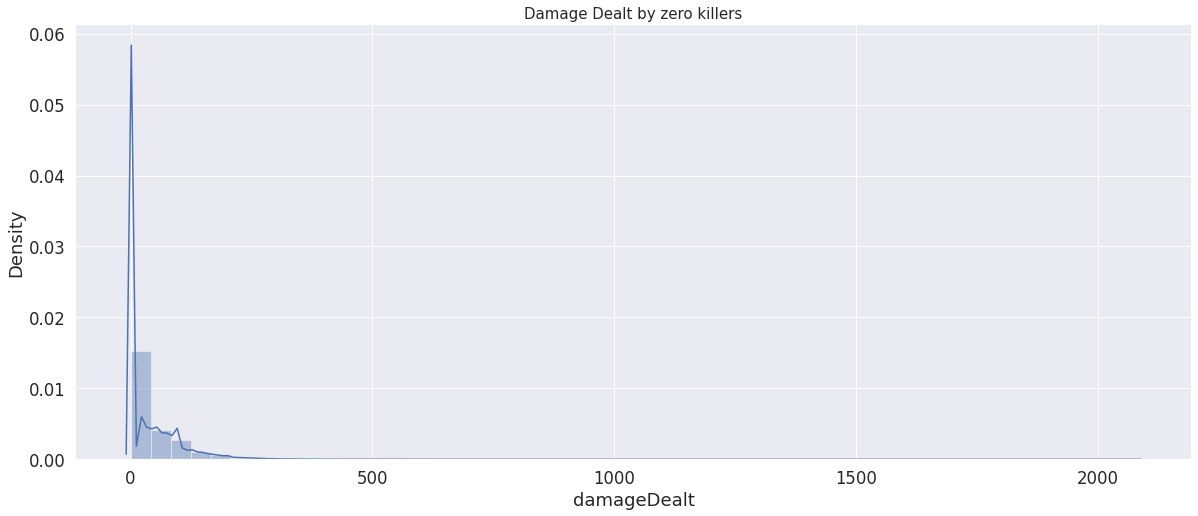

In [ ]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(20,8))
plt.title("Damage Dealt by zero killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

In [ ]:
print("A total of {} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))
data1 = train[train['damageDealt'] == 0].copy()
print("A total of {} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

A total of 16666 players (0.3748%) have won without a single kill!
A total of 4770 players (0.1073%) have won without dealing damage!


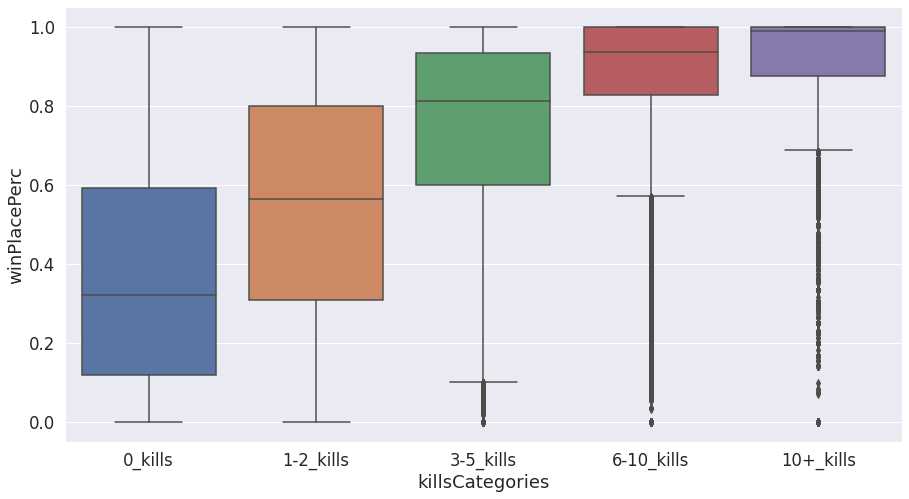

In [ ]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

**RUNNING**

In [ ]:
print("{} players ({:.4f}%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

98054 players (2.0329%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).


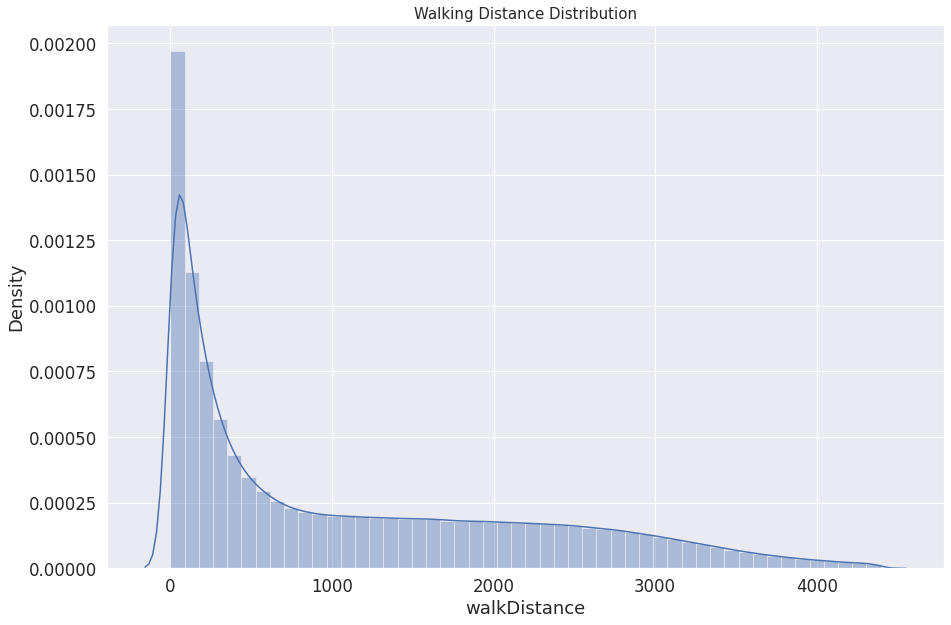

In [ ]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

*Effect of running on Winning Percentage*



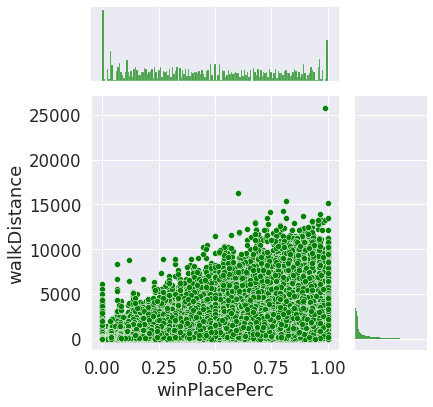

In [ ]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=6, ratio=3, color="green")
plt.show()

**RIDING**

In [ ]:
print("An average person drives for {:.1f}m, 99% of people have drived {}m or less, while THE rider ride for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

An average person drives for 606.1m, 99% of people have drived 6966.0m or less, while THE rider ride for 40710.0m.


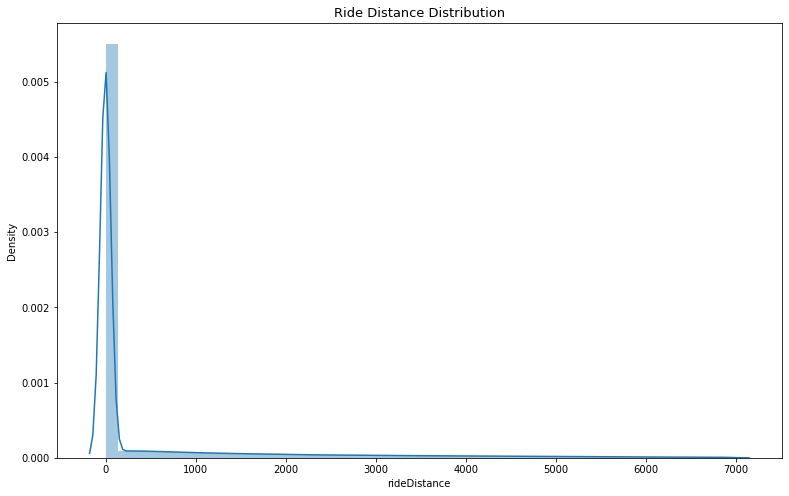

In [ ]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.99)]
plt.figure(figsize=(13,8))
plt.title("Ride Distance Distribution",fontsize=13)
sns.distplot(data['rideDistance'])
plt.show()

In [ ]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they like trekking more than riding.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

3309429 players (23.1022%) drived for 0 meters. This means that they like trekking more than riding.


*Effect of Riding on Winning Percentage*

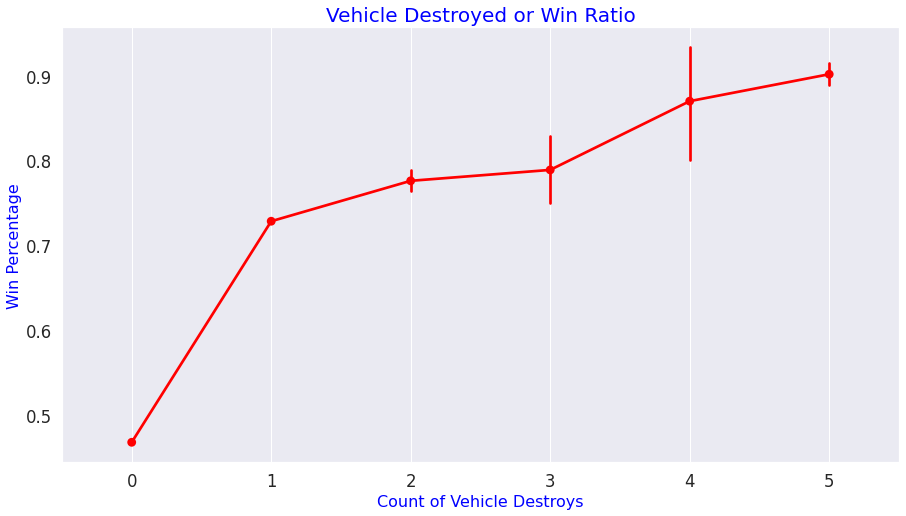

In [ ]:
f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='red',alpha=0.5)
plt.xlabel('Count of Vehicle Destroys',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Vehicle Destroyed or Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

If a player is able to destroy the vehicle it indicates that player might get eliminated or knockout which leads to increase in win Ratio

**Healing and Boosting**

In [ ]:
print("In the game on an average a person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("In the game on an average a person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

In the game on an average a person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
In the game on an average a person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


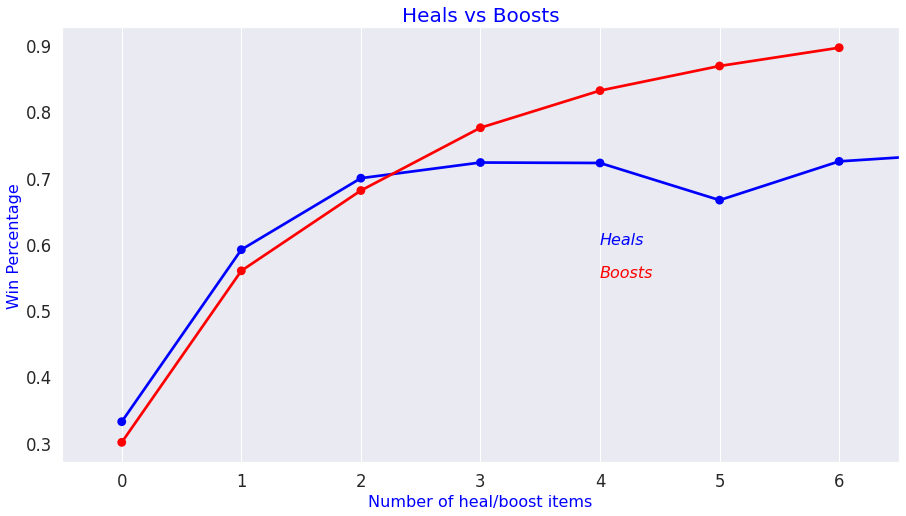

In [ ]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='blue',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='red',alpha=0.8)
plt.text(4,0.6,'Heals',color='blue',fontsize = 16,style = 'italic')
plt.text(4,0.55,'Boosts',color='red',fontsize = 16,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

*Effect of Healing & Boosting on Winning Percentage*

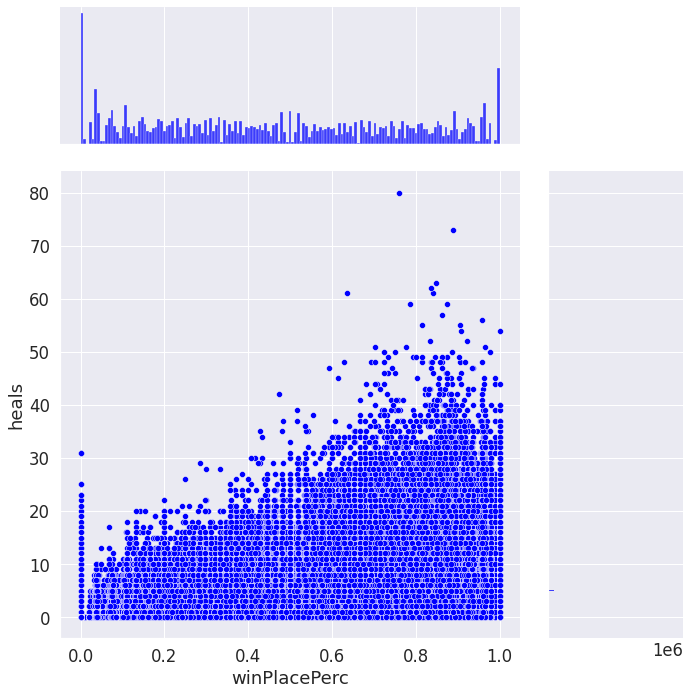

In [ ]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="blue")
plt.show()

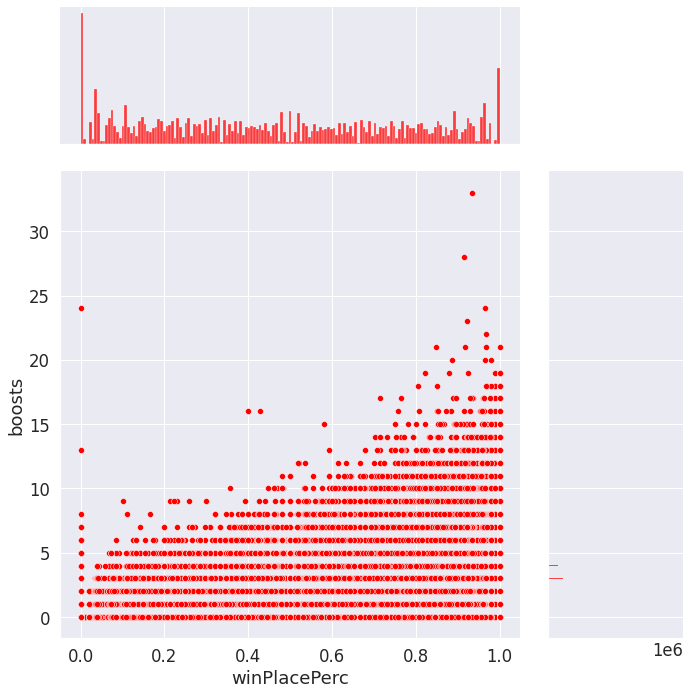

In [ ]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="red")
plt.show()

*Healing and Boosts have a high correlation with winning, however boosts matter more. However we can see abnormal behaviour at starting point*

# *Effect of Killing  Solo, Duos and Squad on Winning Percentage*

In [ ]:
solos = train[train['numGroups']>50] #Solo game > 50 players
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)] #for Duo max 50duos 
squads = train[train['numGroups']<=25] # For Squad max 25squads
print("{} ({:.2f}%) of games are solo, {} ({:.2f}%) are duo and {} ({:.2f}%) are squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

709111 (15.95%) of games are solo, 3295326 (74.10%) are duo and 442529 (9.95%) are squad games.


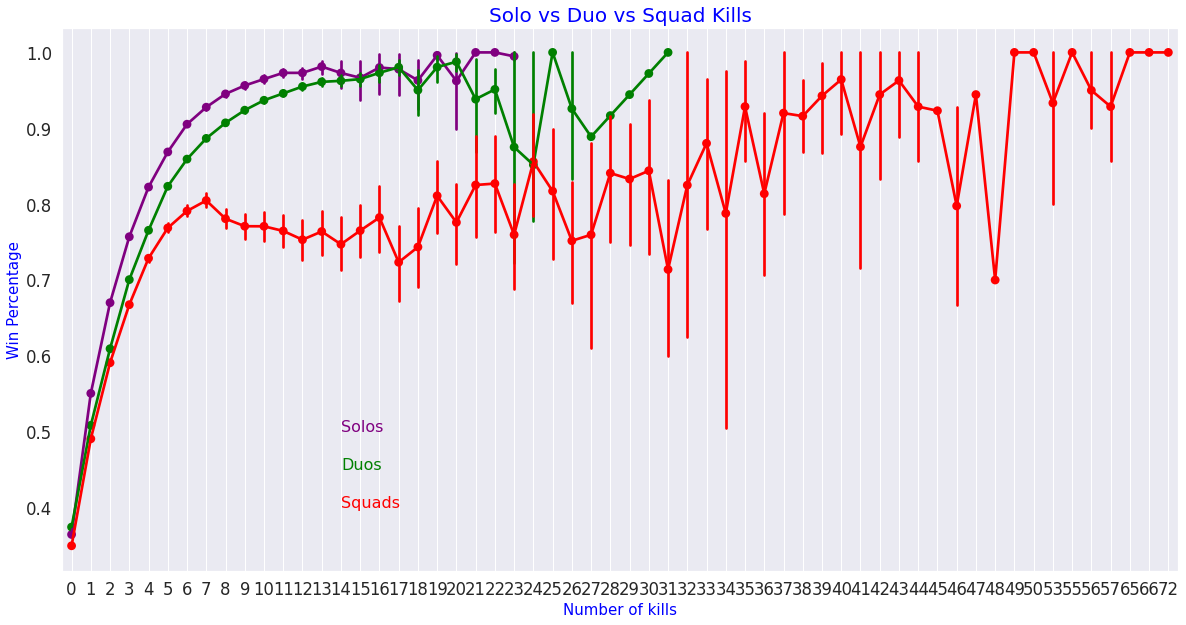

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='purple',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='green',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='red',alpha=0.6)
plt.text(14,0.5,'Solos',color='purple',fontsize = 16)
plt.text(14,0.45,'Duos',color='green',fontsize = 16)
plt.text(14,0.4,'Squads',color='red',fontsize = 16)
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

# *Effect of Knocking (DBNOs), Assisting or Reviving on Winning Percentage*

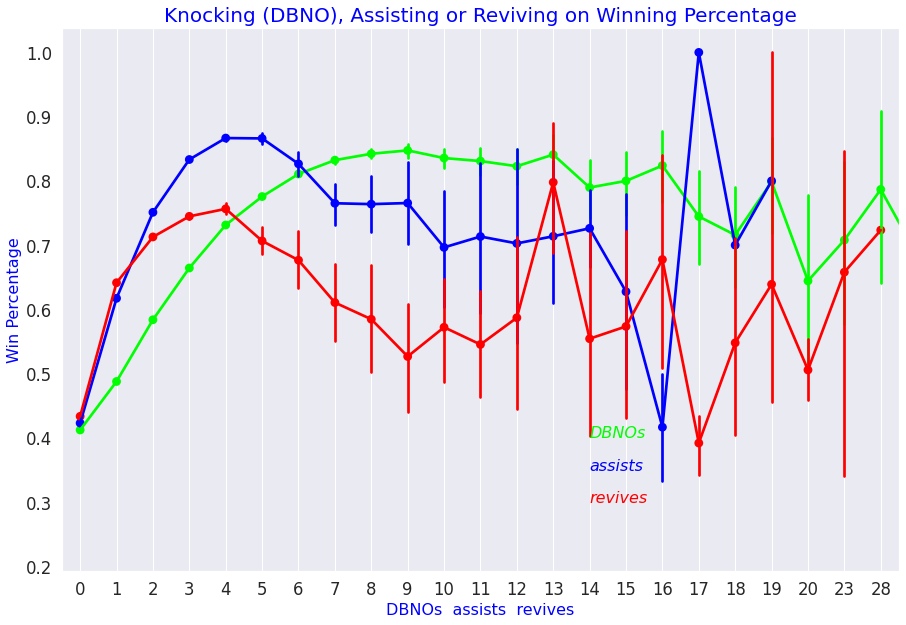

In [ ]:

f,ax1 = plt.subplots(figsize =(15,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=data,color='blue',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=data,color='red',alpha=0.8)
plt.text(14,0.4,'DBNOs',color='lime',fontsize = 16,style = 'italic')
plt.text(14,0.35,'assists',color='blue',fontsize = 16,style = 'italic')
plt.text(14,0.3,'revives',color='red',fontsize = 16,style = 'italic')
plt.xlabel('DBNOs  assists  revives',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Knocking (DBNO), Assisting or Reviving on Winning Percentage',fontsize = 20,color='blue')
plt.grid()
plt.show()

# ***HACKERS.....***

In [ ]:
#illegal matches with NaN value
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [ ]:
train.drop(train[train['winPlacePerc'].isnull()].index, inplace=True)

In [ ]:
#Dimensions
train.shape

(4349359, 32)

# ***AIM HACK..***

In [ ]:
#New Feature totalDistance
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

In [ ]:
# New Feature headshot_rate feature --- headshots made per kill
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

In [ ]:
#Defining some functions for plotting graphs
def show_countplot(column):
    plt.figure(figsize=(15,8))
    sns.countplot(data=train, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(15, 8))
    sns.distplot(train[column], bins=50)
    plt.show()

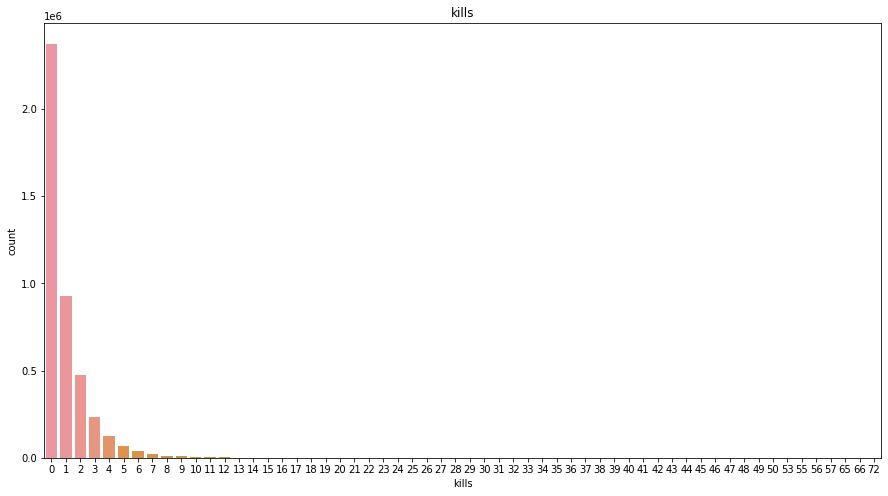

In [ ]:
show_countplot('kills')

In [ ]:
train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['totalDistance'] < 100.0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.949997,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,23.709999,61,0,0.7000,23.709999,0.250000,False
672993,da31f191ace8ed,ce9a3c4950a8f2,17dea22cefe62a,10,0,5793.0,0,5,2,1,0,57,5,104.199997,1798,normal-duo-fpp,15,12,1500,0,0.0,0,0.0,0,0,24.270000,56,0,1.0000,24.270000,0.087719,False
770454,2ade4369bccd12,9f9e64a3db8384,e024bf51bf1799,12,0,5557.0,0,7,4,1,0,55,6,74.790001,1798,normal-solo-fpp,19,18,1500,0,0.0,0,0.0,0,0,85.550003,66,0,1.0000,85.550003,0.127273,False
1378200,f241fdbb4f94c6,fadbbc4cbb3e06,e024bf51bf1799,9,0,3707.0,0,5,1,5,0,41,4,188.100006,1798,normal-solo-fpp,19,18,1500,0,0.0,0,0.0,0,0,46.709999,72,0,0.7778,46.709999,0.121951,False


In [ ]:
train[(train['kills'] >= 40) & (train['heals'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,1000,42,5,266.200012,844,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,1,0,718.299988,16,1500,1.0,718.299988,0.952381,False
2105633,770c02791306c4,48ca6706a90e10,6ee2c835176181,8,0,4272.0,40,34,0,1,0,43,9,248.800003,911,normal-squad-fpp,6,6,1500,1,0.0,0,0.0,0,0,80.400002,21,0,1.0,80.400002,0.790698,False
2316123,dbc81aa64a7e3d,c50fe5c54e8bb6,5d58307bae9b50,8,0,4106.0,31,3,0,1,0,40,6,365.200012,1066,normal-squad-fpp,10,9,1500,0,0.0,0,0.0,0,0,1282.000000,22,0,1.0,1282.000000,0.075000,False
2601666,436d1530e9eb00,5c974c2bb9d9f0,fe7043ee6221c8,5,0,4347.0,0,31,0,1,0,53,8,135.600006,1116,normal-solo-fpp,37,26,1500,0,0.0,0,0.0,0,0,134.300003,36,0,1.0,134.300003,0.584906,False
3924729,579949f753978c,108f4c00d80882,ff9cd80c0d8fb7,1,2,3680.0,0,35,0,1,1000,40,20,621.799988,799,normal-squad-fpp,10,10,-1,0,0.0,0,0.0,0,0,1180.000000,2,1500,1.0,1180.000000,0.875000,False


In [ ]:
# Drop 'fraudsters' with inhumane kill counts
train.drop(train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['totalDistance'] < 100.0)].index, inplace=True)
train.drop(train[(train['kills'] >= 40) & (train['heals'] == 0)].index, inplace=True)

# 100% HeadShots

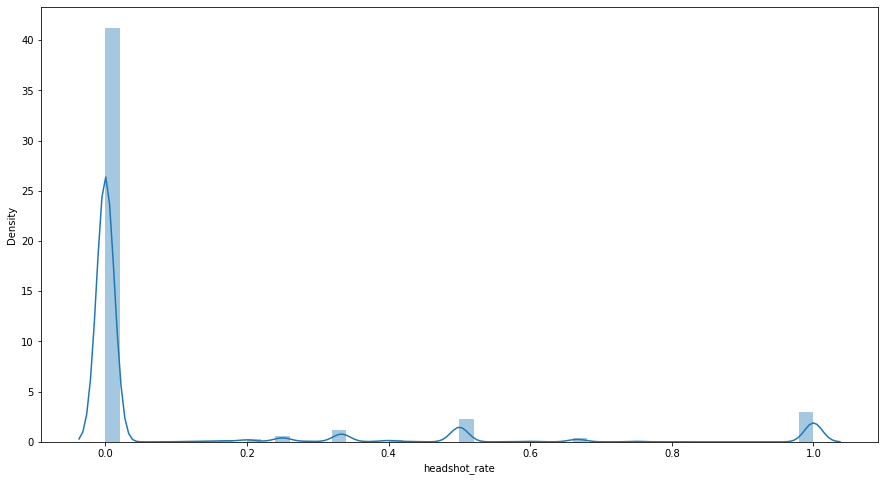

In [ ]:
show_distplot('headshot_rate')

In [ ]:
# Player having  more than 10 kills and all the kills were done by headshot
display(train[(train['headshot_rate'] == 1) & (train['kills'] >=10)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] >= 10)].head(10)

(24, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.199997,1423,squad-fpp,27,25,1564,1,0.000000,0,0.000000,0,0,2939.0,5,0,0.8462,2939.000000,1.0,False
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.599976,1727,squad,27,26,-1,3,4720.000000,0,0.000000,0,0,3422.0,8,1560,1.0000,8142.000000,1.0,False
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.799988,1255,squad,27,27,-1,0,0.000000,0,0.000000,0,0,2105.0,5,1587,1.0000,2105.000000,1.0,False
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.200012,1838,squad-fpp,28,24,-1,0,5187.000000,0,0.000000,2,0,2761.0,7,1519,0.9630,7948.000000,1.0,False
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.000000,1417,squad,27,26,-1,0,1018.000000,0,0.000000,0,0,2458.0,4,1562,1.0000,3476.000000,1.0,False
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,484.899994,1821,squad-fpp,28,27,1495,0,5246.000000,0,0.000000,0,0,2932.0,4,0,1.0000,8178.000000,1.0,False
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.000000,1246,squad-fpp,27,27,-1,0,408.899994,0,0.000000,0,0,2450.0,7,1468,1.0000,2858.899902,1.0,False
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.000000,1730,squad-fpp,28,28,1560,0,2048.000000,0,0.000000,0,0,3915.0,5,0,1.0000,5963.000000,1.0,False
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.600006,1248,duo,46,41,0,1,0.000000,0,0.000000,0,0,3108.0,7,1500,1.0000,3108.000000,1.0,False
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.139999,1379,duo-fpp,49,48,1813,0,0.000000,0,140.800003,0,0,2339.0,4,0,1.0000,2479.800049,1.0,False


In [ ]:
# Create feature killsWithoutMoving
train['_killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))
# Check players who kills without moving
display(train[train['_killsWithoutMoving'] == True].shape)
train[train['_killsWithoutMoving'] == True].head(10)

(0, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving


In [ ]:
# Drop kill without moving 'fraudsters'
train.drop(train[train['_killsWithoutMoving'] == True].index, inplace=True)

# Killing from unexpected long range

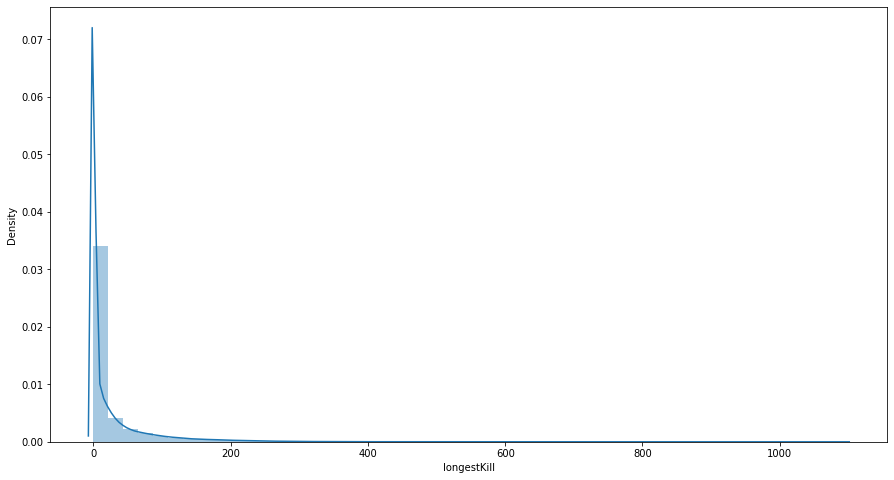

In [ ]:
show_distplot('longestKill')

In [ ]:
train[train['longestKill'] >= 1000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.900024,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.200012,0,0.000000,0,1,3052.000000,9,0,0.9231,3775.199951,0.250000,False
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.000000,8,5,7,18,1000,11,2,1004.0,1308,normal-duo-fpp,14,13,-1,1,0.000000,0,0.000000,0,0,48.869999,38,1500,0.5385,48.869999,0.454545,False
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.000000,0,0,0,9,0,10,2,1026.0,698,normal-squad-fpp,13,13,1500,0,1717.000000,0,0.000000,0,0,1264.000000,26,0,1.0000,2981.000000,0.000000,False
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.000000,17,5,0,3,1000,16,4,1000.0,1091,normal-squad-fpp,6,6,-1,4,0.000000,0,0.000000,0,0,29.209999,30,1500,0.6000,29.209999,0.312500,False
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.800003,0,0,0,51,0,1,1,1075.0,471,normal-squad-fpp,8,8,1500,0,2085.000000,0,0.000000,0,0,1074.000000,22,0,0.0000,3159.000000,0.000000,False
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.000000,11,5,0,5,0,10,3,1094.0,1021,normal-squad-fpp,12,12,1500,0,0.000000,0,0.000000,0,0,569.500000,18,0,0.9091,569.500000,0.500000,False
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.299988,0,0,2,45,1000,3,1,1037.0,581,normal-squad-fpp,8,7,-1,0,0.000000,0,0.000000,0,0,832.500000,9,1500,0.2857,832.500000,0.000000,False
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.000000,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.000000,0,0.000000,0,0,2848.000000,4,1500,0.9412,2848.000000,0.466667,False
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.000000,0,4,11,11,0,23,2,1005.0,1798,normal-duo-fpp,15,12,1500,0,0.000000,0,0.000000,0,0,235.300003,41,0,0.5000,235.300003,0.173913,False
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.000000,0,6,5,15,0,11,2,1037.0,1794,normal-squad-fpp,11,11,1500,0,0.000000,0,0.000000,0,0,133.199997,43,0,0.6000,133.199997,0.545455,False


In [ ]:
# Drop longestKill 'fraudsters'
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

# Road Kills

In [ ]:
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181000,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.000000,0,1371,0.4286,1282.302002,0.000000,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.599976,5,1533,0.4713,4934.600098,0.000000,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290001,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.000000,4,1568,1.0000,5876.000000,0.050000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.399994,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.000000,10,1606,0.9398,7853.000000,0.277778,False


In [ ]:
# Drop roadKill 'fraudsters'
train.drop(train[train['roadKills'] > 10].index, inplace=True)

# Anomaly in travelling

In [ ]:
train[['walkDistance', 'rideDistance', 'swimDistance']].describe()

,walkDistance,rideDistance,swimDistance
count,4.289138e+06,4.289138e+06,4.289138e+06
mean,1.124527e+03,4.450243e+02,4.371119e+00
std,1.180939e+03,1.197167e+03,2.939937e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.470000e+02,0.000000e+00,0.000000e+00
50%,6.251000e+02,0.000000e+00,0.000000e+00
75%,1.947000e+03,0.000000e+00,0.000000e+00
max,2.578000e+04,3.540000e+04,3.823000e+03


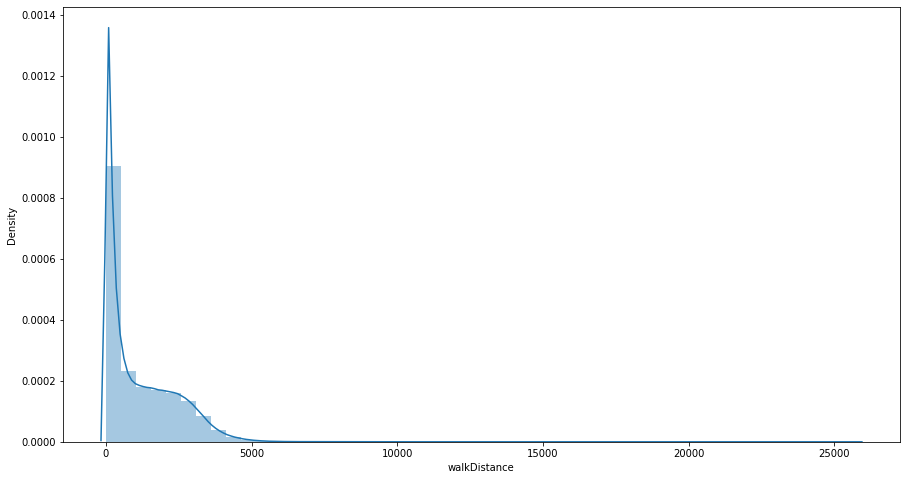

In [ ]:
show_distplot('walkDistance')

In [ ]:
train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.000000,0,0,0,44,0,0,0,0.0,1906,solo,99,93,1517,0,0.421200,0,9.882000,0,0,13530.0,7,0,0.8163,13540.302734,0.0,False
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0,0.000000,0,0,0,46,0,0,0,0.0,1889,solo-fpp,95,93,1520,0,0.007800,0,381.899994,0,0,25780.0,0,0,0.9894,26161.908203,0.0,False
1072113,692e7657b6e340,10baa5ce3cdffe,ad7403ad4d20a9,0,1,0.000000,0,0,5,50,0,0,0,0.0,1962,squad-fpp,29,27,1478,0,0.019800,0,15.270000,1,0,13040.0,4,0,0.6786,13055.289062,0.0,False
1137979,3c23cf6c61171f,90b6aaaa2a16b7,a52c5ac7c18311,0,2,0.000000,0,0,27,41,0,0,0,0.0,1869,squad-fpp,29,29,1470,0,0.054800,0,80.339996,0,0,13160.0,3,0,0.9643,13240.394531,0.0,False
1188935,2dd8f83eb3bd7f,d1e7809ff69bb4,c8585bc8a88aa6,0,0,0.000000,0,0,0,44,0,0,0,0.0,1811,squad-fpp,29,27,1407,0,1258.000000,0,180.699997,0,0,13360.0,4,0,0.9643,14798.700195,0.0,False
1797162,7b9a750b17e9c6,2d00192e4029c5,6fe77402ddb0e1,0,0,0.000000,0,0,0,55,0,0,0,0.0,1977,squad-fpp,26,25,1482,0,0.040100,0,129.399994,0,0,16250.0,3,0,0.6000,16379.440430,0.0,False
2078996,1284474083cc33,fa7e10443cc7df,c62835e88e61a6,0,2,0.000000,0,0,3,48,0,0,0,0.0,2012,squad-fpp,31,31,1474,0,847.700012,0,256.899994,0,0,14250.0,8,0,0.8000,15354.600586,0.0,False
2238900,861d1e5a63f3e6,1da6a90addf96d,16f2c51578f323,0,1,0.000000,0,0,5,46,0,0,0,0.0,1828,solo,97,95,1651,0,0.011100,0,389.500000,0,0,15370.0,7,0,0.8125,15759.510742,0.0,False
2990339,fc3fdd39dcd266,f901321bc27871,c0ebfb404aaa47,0,4,75.349998,0,0,0,40,0,0,0,0.0,1805,squad-fpp,29,29,1542,0,1790.000000,0,42.189999,0,0,13070.0,4,0,0.9286,14902.190430,0.0,False
3318429,25a548c95fa48f,978df298b094ba,99407bcde7569c,0,0,0.000000,0,0,2,39,0,0,0,0.0,1867,solo-fpp,93,89,1803,0,0.013900,0,38.439999,0,0,13660.0,1,0,0.8913,13698.454102,0.0,False


In [ ]:
train.drop(train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)].index, inplace=True)

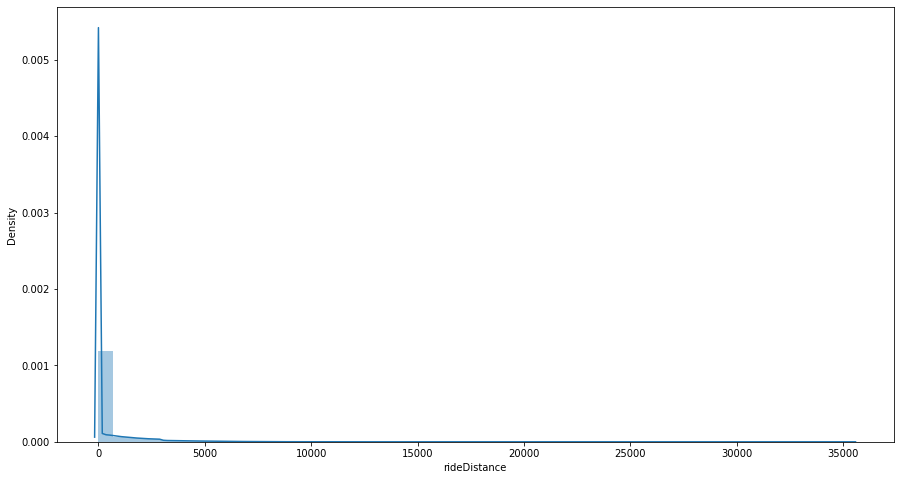

In [ ]:
show_distplot('rideDistance')

In [ ]:
train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.000000,0,0,2,43,1120,0,0,0.0,2007,solo,83,83,-1,0,31960.0,0,0.0,0,0,402.100006,3,1449,0.8171
605623,8dee54600c67ca,e77f3e175b5959,26bc606cdae6bf,0,0,11.210000,0,0,0,27,1179,0,0,0.0,1851,solo,51,50,-1,0,33970.0,0,0.0,0,0,1641.000000,0,1498,0.6800
1232362,4bf27787223351,b0140dd17f3238,5ed9c405f7e71d,0,1,0.000000,0,0,10,47,0,0,0,0.0,1896,solo,95,91,1501,0,31010.0,0,0.0,1,0,1473.000000,3,0,0.7979
1725337,9f14f77b6dd9b6,8a2a8ae2506323,904b5fa7f59bc5,0,2,2.389000,0,0,5,19,1193,0,0,0.0,1918,solo-fpp,37,35,-1,0,37670.0,0,0.0,0,0,542.099976,2,1565,0.6944
2137063,73b793b4e7523f,f4444641af7e5c,6385f7641268c3,0,0,0.000000,0,0,0,52,0,0,0,0.0,1794,solo-fpp,94,92,1512,0,31370.0,0,0.0,0,0,28.760000,0,0,0.7204
2700691,3428324a089608,fa77b4ac736dbf,9b1c87f4016f47,0,1,31.270000,0,0,0,46,1211,0,0,0.0,1886,solo-fpp,98,95,-1,0,31290.0,0,0.0,0,0,174.100006,1,1530,0.8557
2927408,260efc0cf6b36c,b112f8d21e8185,3e977510ce1d3c,0,0,11.220000,0,0,0,44,1281,0,0,0.0,1865,solo,92,90,-1,0,30660.0,0,0.0,0,0,426.600006,2,1619,0.8132
3404578,8e84f4228e5436,c5ca5892142cbd,56775920f704e8,0,0,3.298000,0,0,0,40,1060,0,0,0.0,1877,solo-fpp,98,96,-1,0,32320.0,0,0.0,0,0,233.699997,5,1497,0.9175
3567265,99f342c6022411,9158efebffecc7,ddbe41fe165c7f,2,2,113.199997,0,0,3,34,0,0,0,0.0,1958,duo-fpp,48,47,1729,1,31020.0,0,0.0,0,0,616.200012,4,0,1.0000
4099938,afe34618b04d77,c14f532b283844,732c3b752e055f,0,0,0.000000,0,0,0,42,0,0,0,0.0,1939,solo-fpp,93,90,1486,0,40710.0,0,0.0,0,0,560.099976,0,0,0.8478


In [ ]:
train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
219621,49e86bcbb74918,5bf4ac7f5f89a0,05a97d10e3cf81,0,0,100.000000,1,0,0,38,0,1,1,2.150000,1979,squad,26,26,1465,0,673.099976,1,0.0,0,0,0.0,0,0,0.0000
1051447,c43116d1c3d4e5,bd09c97b67800a,aad60eee7eeb79,0,0,102.199997,0,0,0,34,1320,1,1,4.489000,1935,solo,89,85,-1,0,1757.000000,1,0.0,0,0,0.0,0,1532,0.1250
1053213,4a8011f19b0e0e,037c89b0cef255,238171821a1d0e,1,0,100.000000,1,0,0,38,1621,1,1,1.440000,1881,duo-fpp,48,45,-1,0,36.240002,0,0.0,0,0,0.0,0,1747,0.0638
1166930,553f199b5538c5,560c2ba9dcbbd0,afb05e37d884fc,2,0,168.500000,1,0,0,45,1398,1,1,3.268000,1799,squad,31,29,-1,0,391.799988,1,0.0,0,0,0.0,0,1499,0.0667
1479750,bcdf0f6c5d08bf,ea2ed2cc5955dd,2b59ed013eaf15,0,0,100.000000,1,0,0,46,0,1,1,3.744000,1882,duo-fpp,50,47,1509,0,468.299988,1,0.0,0,0,0.0,0,0,0.0612
2221273,a280df87d394fc,61042f8c96538c,a0e8fe0599288c,0,0,100.000000,1,0,0,37,0,1,1,4.656000,1982,duo,47,44,1506,0,534.500000,1,0.0,0,0,0.0,0,0,0.1522
2382410,adbda59d2f11cd,343d453ffb18c8,cbb5f864c6f532,0,0,100.000000,1,0,0,43,0,1,1,1.564000,1807,squad,26,22,1530,0,262.700012,1,0.0,0,0,0.0,0,0,0.0000
2471705,b968373063f5a8,536e9c19659ce8,61c90034dc8174,0,0,93.470001,1,0,0,38,0,1,1,3.395000,1758,squad-fpp,29,26,1500,0,1360.000000,1,0.0,0,0,0.0,0,0,0.1429
2907639,2bf1d34142358b,71c15011651348,08dfa30b9390f7,4,0,578.000000,0,0,6,30,0,3,1,17.719999,1007,normal-squad-fpp,6,6,1500,0,1277.000000,0,0.0,0,0,0.0,29,0,0.4000
3778837,ca3ca72549b07f,68a0c84f3b09aa,f72f06cafb3349,0,0,144.300003,2,0,0,20,1183,2,1,5.206000,1785,squad,28,26,-1,0,415.399994,0,0.0,0,0,0.0,0,1496,0.0000


In [ ]:
train[(train['totalDistance'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.0,0,0,0,87,0,0,0,0.0,1530,duo,46,44,1534,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0
116,6adb021f5165ff,58e5500bd40898,de5c692fe25a73,0,0,0.0,0,0,0,68,311,0,0,0.0,1414,duo,41,36,0,0,0.0,0,0.0,0,0,0.0,0,847,0.0000,0.0,0.0
151,a2bbe20aa8789d,926e8a09bab249,e36e4203ed4831,0,0,0.0,0,0,0,92,309,0,0,0.0,1377,duo,48,41,-1,0,0.0,0,0.0,0,0,0.0,0,765,0.0000,0.0,0.0
237,baaa694658e085,d034728f22cff7,fa71620624d3e7,0,0,0.0,0,0,0,94,1397,0,0,0.0,1358,squad-fpp,29,26,-1,0,0.0,0,0.0,0,0,0.0,0,1510,0.0000,0.0,0.0
283,3ab8128e6bcbe6,bb52a209f2e938,aabd2650b129e2,0,0,0.0,0,0,0,84,0,0,0,0.0,1797,duo,48,47,1500,0,0.0,0,0.0,0,0,0.0,0,0,0.1277,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446843,56f1ff8594a328,63008ee9676bc3,b3f07953e112dc,0,0,0.0,0,0,0,99,0,0,0,0.0,1902,squad,30,30,1456,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0
4446849,19d2b52c9e17a3,f8a952ce9ab7aa,2afb2889026133,0,0,0.0,0,0,0,90,1243,0,0,0.0,1472,solo-fpp,98,93,-1,0,0.0,0,0.0,0,0,0.0,0,1363,0.0412,0.0,0.0
4446905,f93dfebceecc59,c54ca5bb9df107,e1da3a1ee799ef,0,0,0.0,0,0,0,89,0,0,0,0.0,1371,duo-fpp,49,48,1465,0,0.0,0,0.0,0,0,0.0,1,0,0.0417,0.0,0.0
4446926,e0c791ea3c4644,e18240dcce54f9,827639896a20cb,0,0,0.0,0,0,0,87,526,0,0,0.0,1811,squad,29,29,-1,0,0.0,0,0.0,0,0,0.0,0,916,0.0000,0.0,0.0


In [ ]:
# droping riding walking totalDistance anomalies
train.drop(train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)].index, inplace = True)
train.drop(train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)].index, inplace = True)
train.drop(train[(train['totalDistance'] == 0)].index, inplace=True)

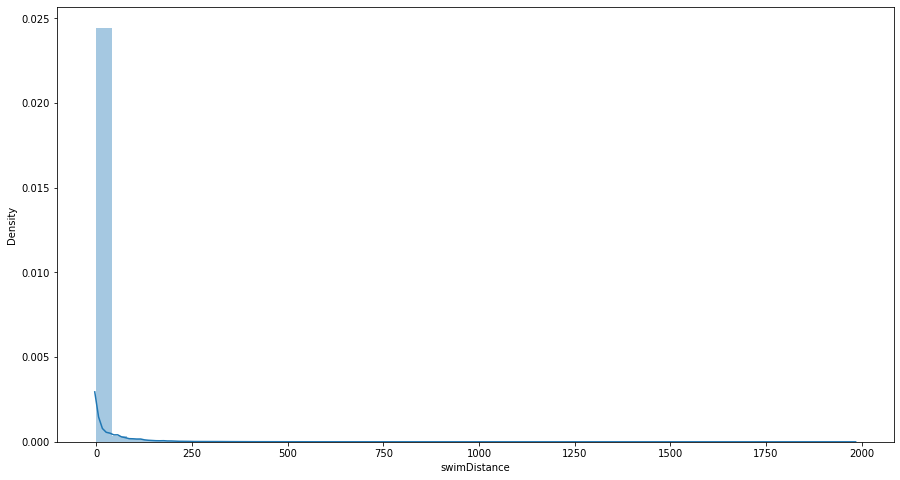

In [ ]:
show_distplot('swimDistance')

In [ ]:
train[train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.120003,1,0,1,47,1058,0,0,0.000000,1399,duo-fpp,50,46,-1,0,0.0,0,2295.0,0,0,1002.000000,4,1466,0.9592,3297.000000,0.000000
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.320000,0,0,16,39,0,0,0,0.000000,2188,squad,26,25,1584,0,5689.0,0,2148.0,0,0,2276.000000,5,0,0.9600,10113.000000,0.000000
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.000000,4,3,1,6,1103,3,1,868.700012,1897,squad,26,25,-1,0,3331.0,0,2718.0,0,0,4691.000000,5,1516,1.0000,10740.000000,1.000000
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.299988,3,1,6,4,1039,5,1,64.480003,1396,duo-fpp,49,48,-1,0,0.0,0,2668.0,0,0,415.100006,10,1499,1.0000,3083.100098,0.200000
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.200012,3,1,1,46,0,2,1,48.209999,1021,normal-squad-fpp,12,12,1500,0,0.0,0,3823.0,0,0,995.299988,9,0,1.0000,4818.299805,0.500000
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.000000,0,0,0,47,0,0,0,0.000000,1387,squad-fpp,25,23,1327,0,864.0,0,2484.0,0,0,1966.000000,3,0,0.5833,5314.000000,0.000000
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.590000,0,0,5,48,1097,0,0,0.000000,1379,duo-fpp,48,46,0,1,2089.0,0,3514.0,0,0,4296.000000,8,1492,0.8511,9899.000000,0.000000
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.399994,2,0,0,7,0,3,2,30.020000,1210,squad-fpp,27,24,1516,0,0.0,0,2387.0,0,0,7.546000,6,0,1.0000,2394.545898,0.000000
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.799988,5,5,2,2,0,7,1,696.799988,2188,squad,26,25,1628,1,3033.0,0,2206.0,0,0,4687.000000,4,0,0.9600,9926.000000,0.714286
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.000000,0,0,0,77,1056,0,0,0.000000,1372,squad-fpp,29,29,-1,0,0.0,0,2338.0,0,0,1750.000000,0,1518,0.2143,4088.000000,0.000000


In [ ]:
# Remove swim anomalies
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

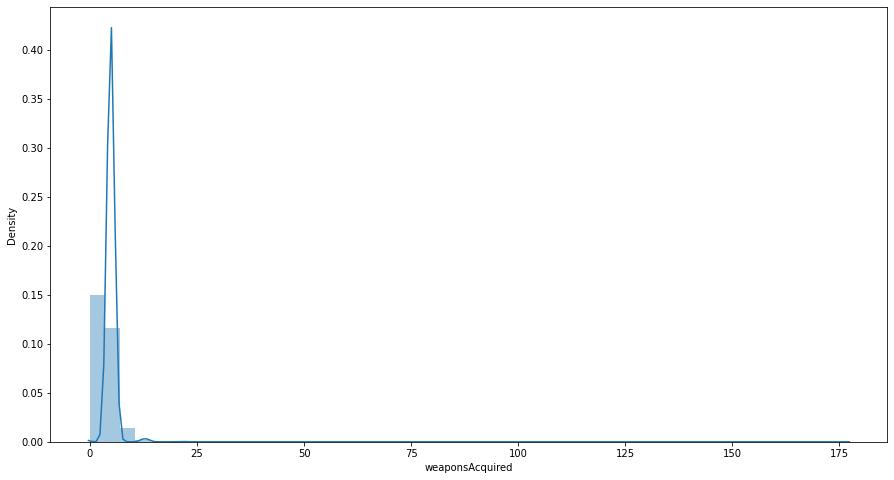

In [ ]:
show_distplot('weaponsAcquired')

In [ ]:
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(19, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.110001,0,0,0,44,1279,0,0,0.000000,1901,duo,46,45,-1,0,1880.000000,0,0.000000,0,0,1307.000000,128,1577,0.7111,3187.000000,0.000000,False
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.300003,1,0,2,48,0,0,0,0.000000,1372,squad,29,29,1473,0,0.000000,0,0.000000,0,0,1687.000000,80,0,0.7500,1687.000000,0.000000,False
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.000000,0,0,0,24,0,1,1,110.599998,1840,squad-fpp,29,28,1528,0,2852.000000,0,47.209999,0,0,2400.000000,102,0,0.8929,5299.209961,0.000000,False
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.000000,0,0,0,54,0,0,0,0.000000,1330,squad-fpp,26,23,1442,0,0.000000,0,0.000000,0,0,653.099976,95,0,0.5600,653.099976,0.000000,False
1462706,be4ff9afaa5bb1,abb73dd57619fa,f900de1ec39fa5,22,0,5377.000000,0,8,4,3,0,53,3,53.610001,1798,normal-solo-fpp,11,11,1500,0,954.400024,0,0.000000,0,0,1128.000000,83,0,0.8000,2082.399902,0.150943,False


In [ ]:
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

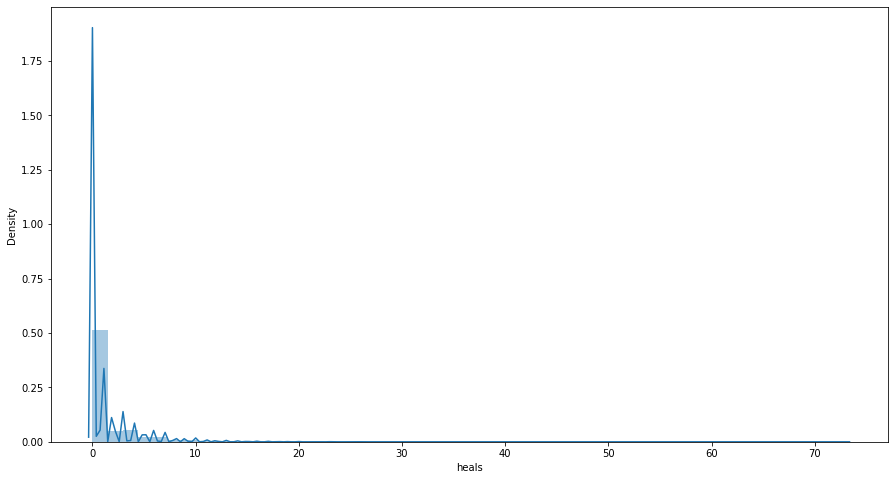

In [ ]:
show_distplot('heals')

In [ ]:
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(111, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_killsWithoutMoving
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.000000,0,1,43,21,0,1,1,5.515000,1532,squad,27,27,1500,0,0.000000,0,292.399994,0,0,2791.000000,7,0,0.9615,3083.399902,1.000000,False
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.000000,0,0,52,49,1331,0,0,0.000000,1374,solo-fpp,97,96,-1,0,0.000000,0,3.443000,0,0,1340.000000,3,1543,0.8333,1343.442993,0.000000,False
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.000000,0,0,42,44,1359,0,0,0.000000,1295,squad-fpp,28,28,-1,0,0.000000,0,0.000000,0,0,2439.000000,2,1511,0.9259,2439.000000,0.000000,False
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.000000,0,0,40,52,0,0,0,0.000000,1965,squad-fpp,30,29,1506,0,2596.000000,0,0.000000,0,0,2252.000000,8,0,0.8276,4848.000000,0.000000,False
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.000000,2,1,47,25,1254,1,1,33.310001,1358,squad-fpp,32,31,-1,0,487.600006,0,0.000000,0,0,2928.000000,3,1562,0.9355,3415.600098,1.000000,False
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.000000,0,8,41,9,1000,27,3,87.190002,1797,normal-solo-fpp,37,22,-1,0,0.000000,0,0.000000,0,0,268.799988,33,1500,0.8889,268.799988,0.296296,False
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.500000,3,1,44,3,1034,4,2,35.419998,1807,squad,28,25,-1,1,2438.000000,0,0.000000,0,0,2489.000000,6,1517,0.9630,4927.000000,0.250000,False
392233,fbfc2e508763a3,311814fbf44202,b1291fd6e70756,0,1,0.000000,0,0,42,25,1127,0,0,0.000000,1906,duo,20,20,-1,0,350.799988,0,0.000000,0,0,2656.000000,3,1565,0.4737,3006.800049,0.000000,False
411846,fb89425038aa32,285def4469bfdf,73c9481567ab30,0,2,21.290001,0,0,44,39,0,0,0,0.000000,1397,solo-fpp,90,88,1580,0,1588.000000,0,0.000000,0,0,1812.000000,3,0,0.8876,3400.000000,0.000000,False
454438,6c55f4a0c9abf7,0e8c11d4f2373a,bc0405a14a18c4,0,8,100.000000,0,1,42,23,0,1,1,33.290001,1949,solo,97,92,1535,0,3707.000000,0,0.000000,0,0,1517.000000,7,0,0.8229,5224.000000,1.000000,False


In [ ]:
train.drop(train[train['heals'] >= 40].index, inplace=True)

In [ ]:
train.shape

(4349383, 31)

# **Adding/Removing some features**

In [ ]:
train.to_csv('/content/drive/My Drive/PUBG/cleaned_data.csv', index=False)

In [ ]:
import pandas as pd
cleaned_data = pd.read_csv('/content/drive/My Drive/PUBG/cleaned_data.csv')
cleaned_data = reduce_mem_usage(cleaned_data)

Memory usage of dataframe is 1028.71 MB --> 360.88 MB (Decreased by 64.9%)


In [ ]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0


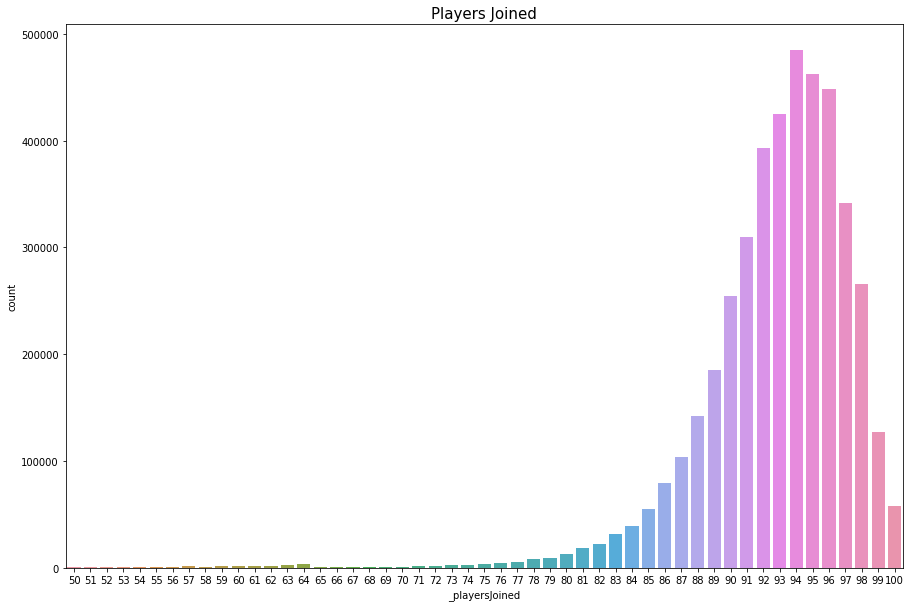

In [ ]:
cleaned_data['_playersJoined'] = cleaned_data.groupby('matchId')['matchId'].transform('count')
data = cleaned_data.copy()
data = data[data['_playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['_playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

In [ ]:
# Create normalized features
cleaned_data['_killsNorm'] = cleaned_data['kills']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_damageDealtNorm'] = cleaned_data['damageDealt']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_maxPlaceNorm'] = cleaned_data['maxPlace']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_matchDurationNorm'] = cleaned_data['matchDuration']*((100-cleaned_data['_playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','_killsNorm','damageDealt', '_damageDealtNorm', 'maxPlace', '_maxPlaceNorm', 'matchDuration', '_matchDurationNorm']
cleaned_data[to_show][0:11]

,Id,kills,_killsNorm,damageDealt,_damageDealtNorm,maxPlace,_maxPlaceNorm,matchDuration,_matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000000,0.000000,28,29.68,1306,1384.36
1,eef90569b9d03c,0,0.00,91.470001,100.617001,26,28.60,1777,1954.70
2,1eaf90ac73de72,0,0.00,68.000000,72.760000,50,53.50,1318,1410.26
3,4616d365dd2853,0,0.00,32.900002,35.861002,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.06,100.000000,106.000000,97,102.82,1424,1509.44
5,ff79c12f326506,1,1.09,100.000000,109.000000,28,30.52,1395,1520.55
6,95959be0e21ca3,0,0.00,0.000000,0.000000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538000,9.221040,96,103.68,1967,2124.36
8,1a68204ccf9891,0,0.00,51.599998,54.179998,28,29.40,1375,1443.75
9,e5bb5a43587253,0,0.00,37.270000,40.251600,29,31.32,1930,2084.40


In [ ]:
match = cleaned_data.groupby('matchId')
cleaned_data['_killsPerc'] = match['kills'].rank(pct=True).values
cleaned_data['_killPlacePerc'] = match['killPlace'].rank(pct=True).values
cleaned_data['_walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
cleaned_data['_damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
cleaned_data['_walkPerc_killsPerc'] = cleaned_data['_walkDistancePerc'] / cleaned_data['_killsPerc']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194


In [ ]:
corr = cleaned_data[['_killsPerc', '_killPlacePerc','_walkDistancePerc','_damageDealtPerc', '_walkPerc_killsPerc','winPlacePerc']].corr()

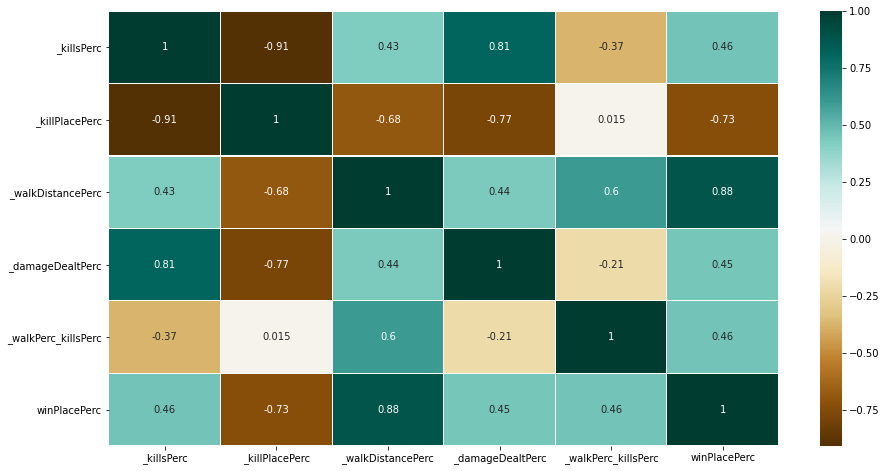

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="BrBG"
)
plt.show()

In [ ]:
agg = cleaned_data.groupby(['groupId']).size().to_frame('players_in_team')
cleaned_data = cleaned_data.merge(agg, how='left', on=['groupId'])
cleaned_data['_healthItems'] = cleaned_data['heals'] + cleaned_data['boosts']
cleaned_data['_headshotKillRate'] = cleaned_data['headshotKills'] / cleaned_data['kills']
cleaned_data['_killPlaceOverMaxPlace'] = cleaned_data['killPlace'] / cleaned_data['maxPlace']
cleaned_data['_killsOverWalkDistance'] = cleaned_data['kills'] / cleaned_data['walkDistance']
cleaned_data['_killsOverDistance'] = cleaned_data['kills'] / cleaned_data['totalDistance']
cleaned_data['_walkDistancePerSec'] = cleaned_data['walkDistance'] / cleaned_data['matchDuration']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,_killsOverDistance,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,NaN,2.142857,0.000000,0.000000,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,NaN,2.192308,0.000000,0.000000,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,NaN,0.940000,0.000000,0.000000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,NaN,2.419355,0.000000,0.000000,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.0,0.463918,0.020101,0.020101,0.034937


In [ ]:
corr = cleaned_data[['killPlace', 'walkDistance','_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance', '_killsOverDistance','_walkDistancePerSec','winPlacePerc']].corr()

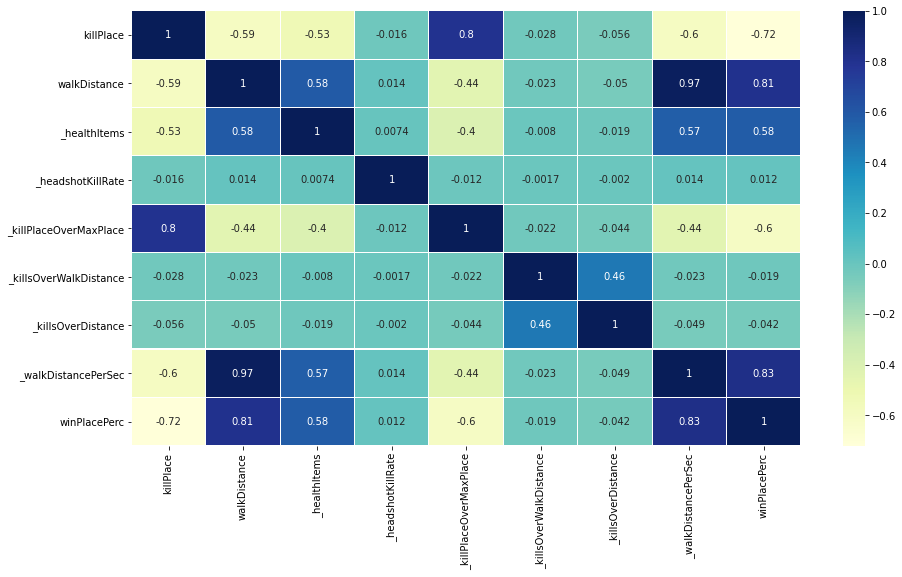

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="YlGnBu"
)
plt.show()

In [ ]:
cleaned_data.shape

(4349518, 48)

In [ ]:
cleaned_data.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'totalDistance',
       'headshot_rate', '_playersJoined', '_killsNorm', '_damageDealtNorm',
       '_maxPlaceNorm', '_matchDurationNorm', '_killsPerc', '_killPlacePerc',
       '_walkDistancePerc', '_damageDealtPerc', '_walkPerc_killsPerc',
       'players_in_team', '_healthItems', '_headshotKillRate',
       '_killPlaceOverMaxPlace', '_killsOverWalkDistance',
       '_killsOverDistance', '_walkDistancePerSec'],
      dtype='object')

In [ ]:
cleaned_data.drop(['_headshotKillRate','_killsOverDistance', '_killsOverWalkDistance', ], axis=1, inplace=True)

In [ ]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,headshot_rate,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_killPlaceOverMaxPlace,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,2.142857,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,2.192308,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,0.940000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,2.419355,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.463918,0.034937


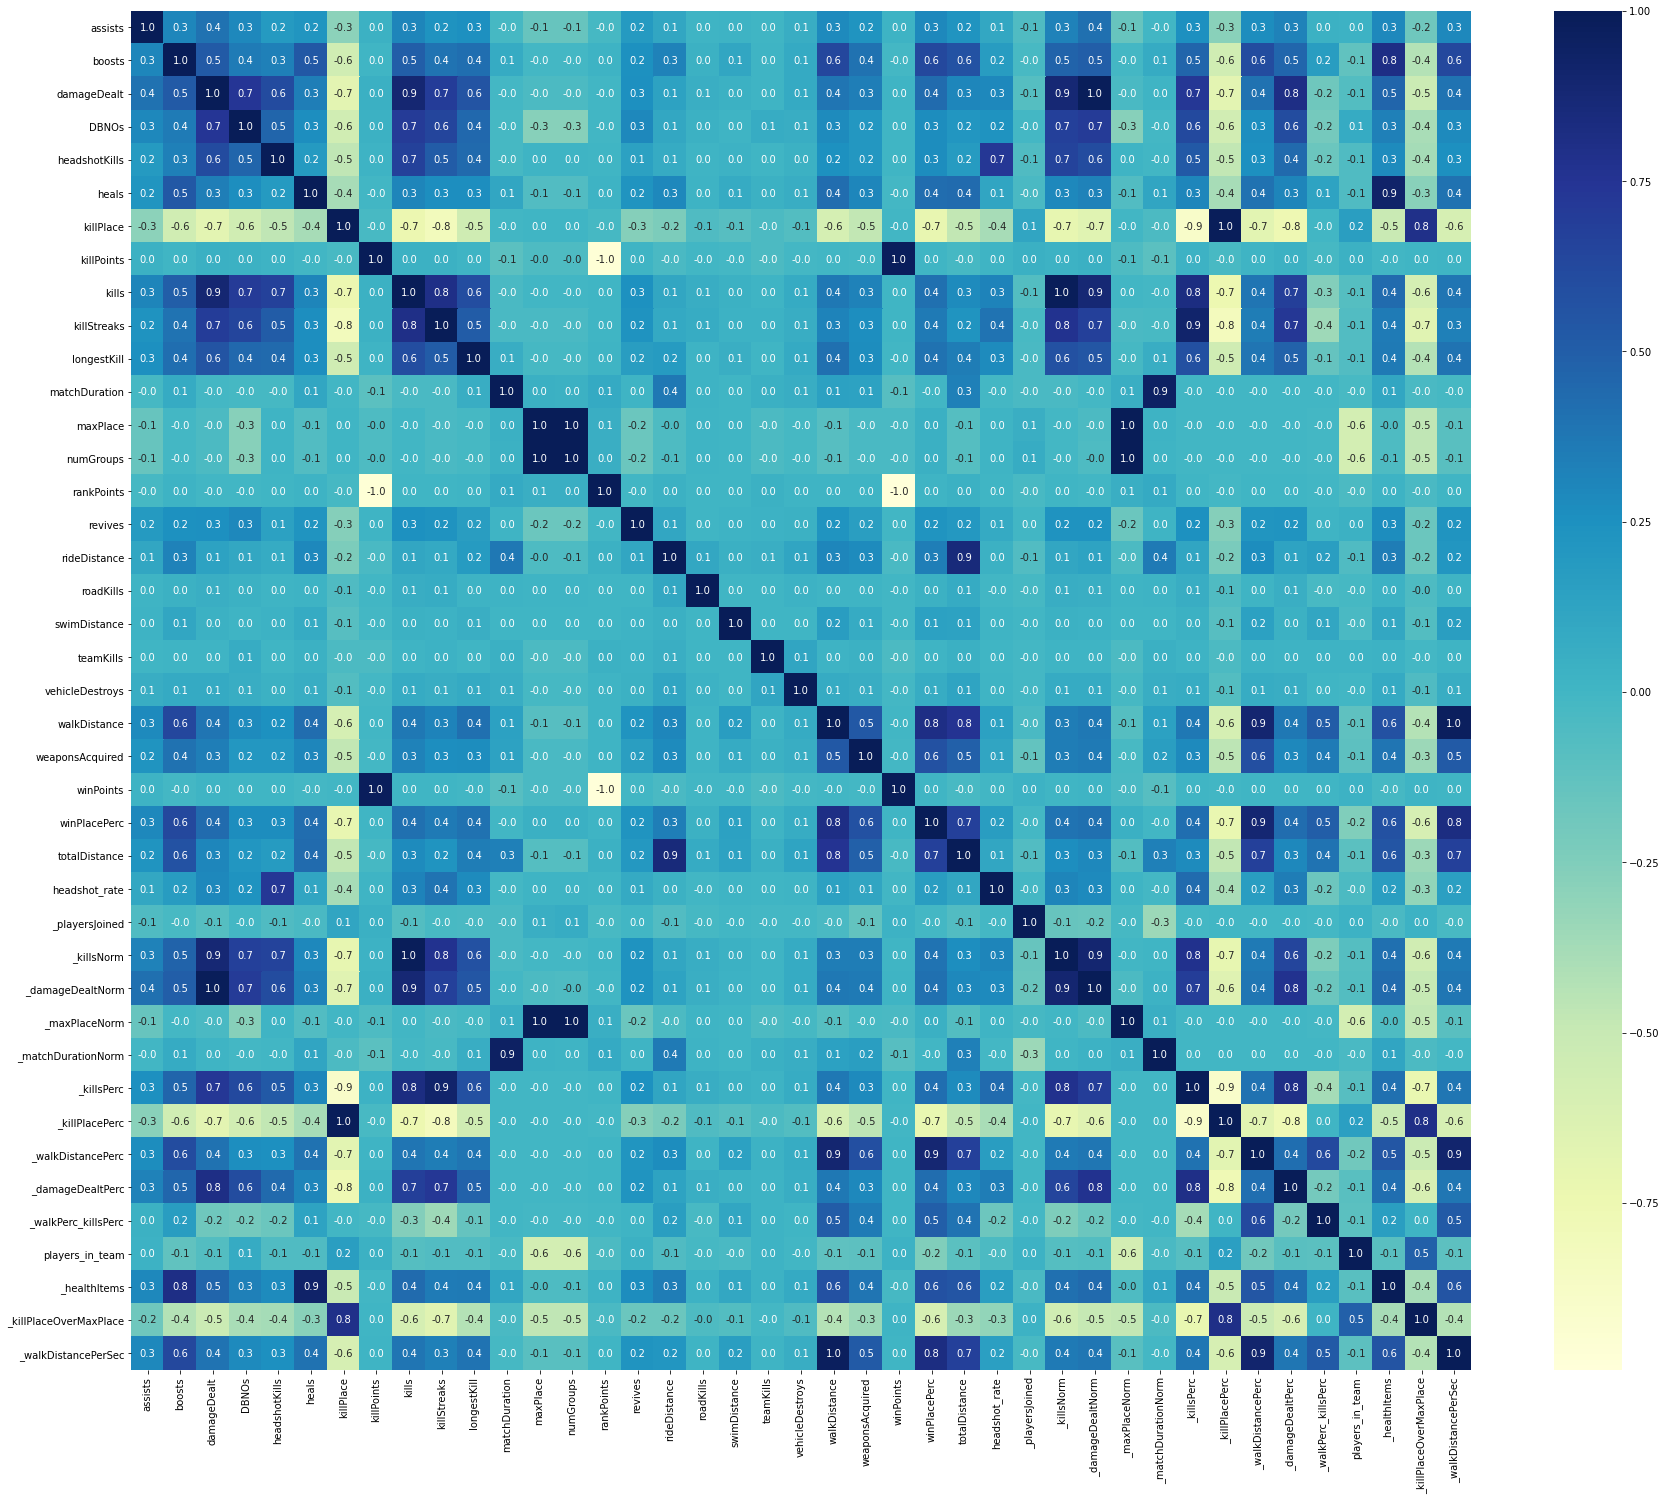

In [ ]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 25))
sns.heatmap(cleaned_data[cols_to_fit].corr(), annot=True, fmt= '.1f',ax=ax, cmap="YlGnBu")
sns.set(font_scale=1.25)
plt.show()

##Removing features having 0 correlation with winPlacePerc

In [ ]:
cleaned_data.drop(['killPoints','matchDuration','maxPlace','numGroups','rankPoints','roadKills','teamKills','winPoints', '_playersJoined', '_maxPlaceNorm', '_matchDurationNorm'], axis=1, inplace=True)

In [ ]:
cleaned_data.shape

(4349518, 34)

In [ ]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchType,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,headshot_rate,_killsNorm,_damageDealtNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_killPlaceOverMaxPlace,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,0,0,0.000000,squad-fpp,0,0.0000,0.00,0,244.800003,1,0.4444,244.800003,0.0,0.00,0.000000,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,2.142857,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0.000000,squad-fpp,0,0.0045,11.04,0,1434.000000,5,0.6400,1445.044556,0.0,0.00,105.190501,0.235294,0.611765,0.588235,0.400000,2.500000,3,0,2.192308,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0.000000,duo,0,0.0000,0.00,0,161.800003,2,0.7755,161.800003,0.0,0.00,72.760000,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,0.940000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0.000000,squad-fpp,0,0.0000,0.00,0,202.699997,3,0.1667,202.699997,0.0,0.00,35.861002,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,2.419355,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,1,1,58.529999,solo-fpp,0,0.0000,0.00,0,49.750000,2,0.1875,49.750000,0.0,1.06,106.000000,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.463918,0.034937


In [ ]:
cleaned_data.drop(['headshot_rate'], axis=1, inplace=True)

In [ ]:
cleaned_data.shape

(4349518, 33)

In [ ]:
test.shape

(1934174, 28)

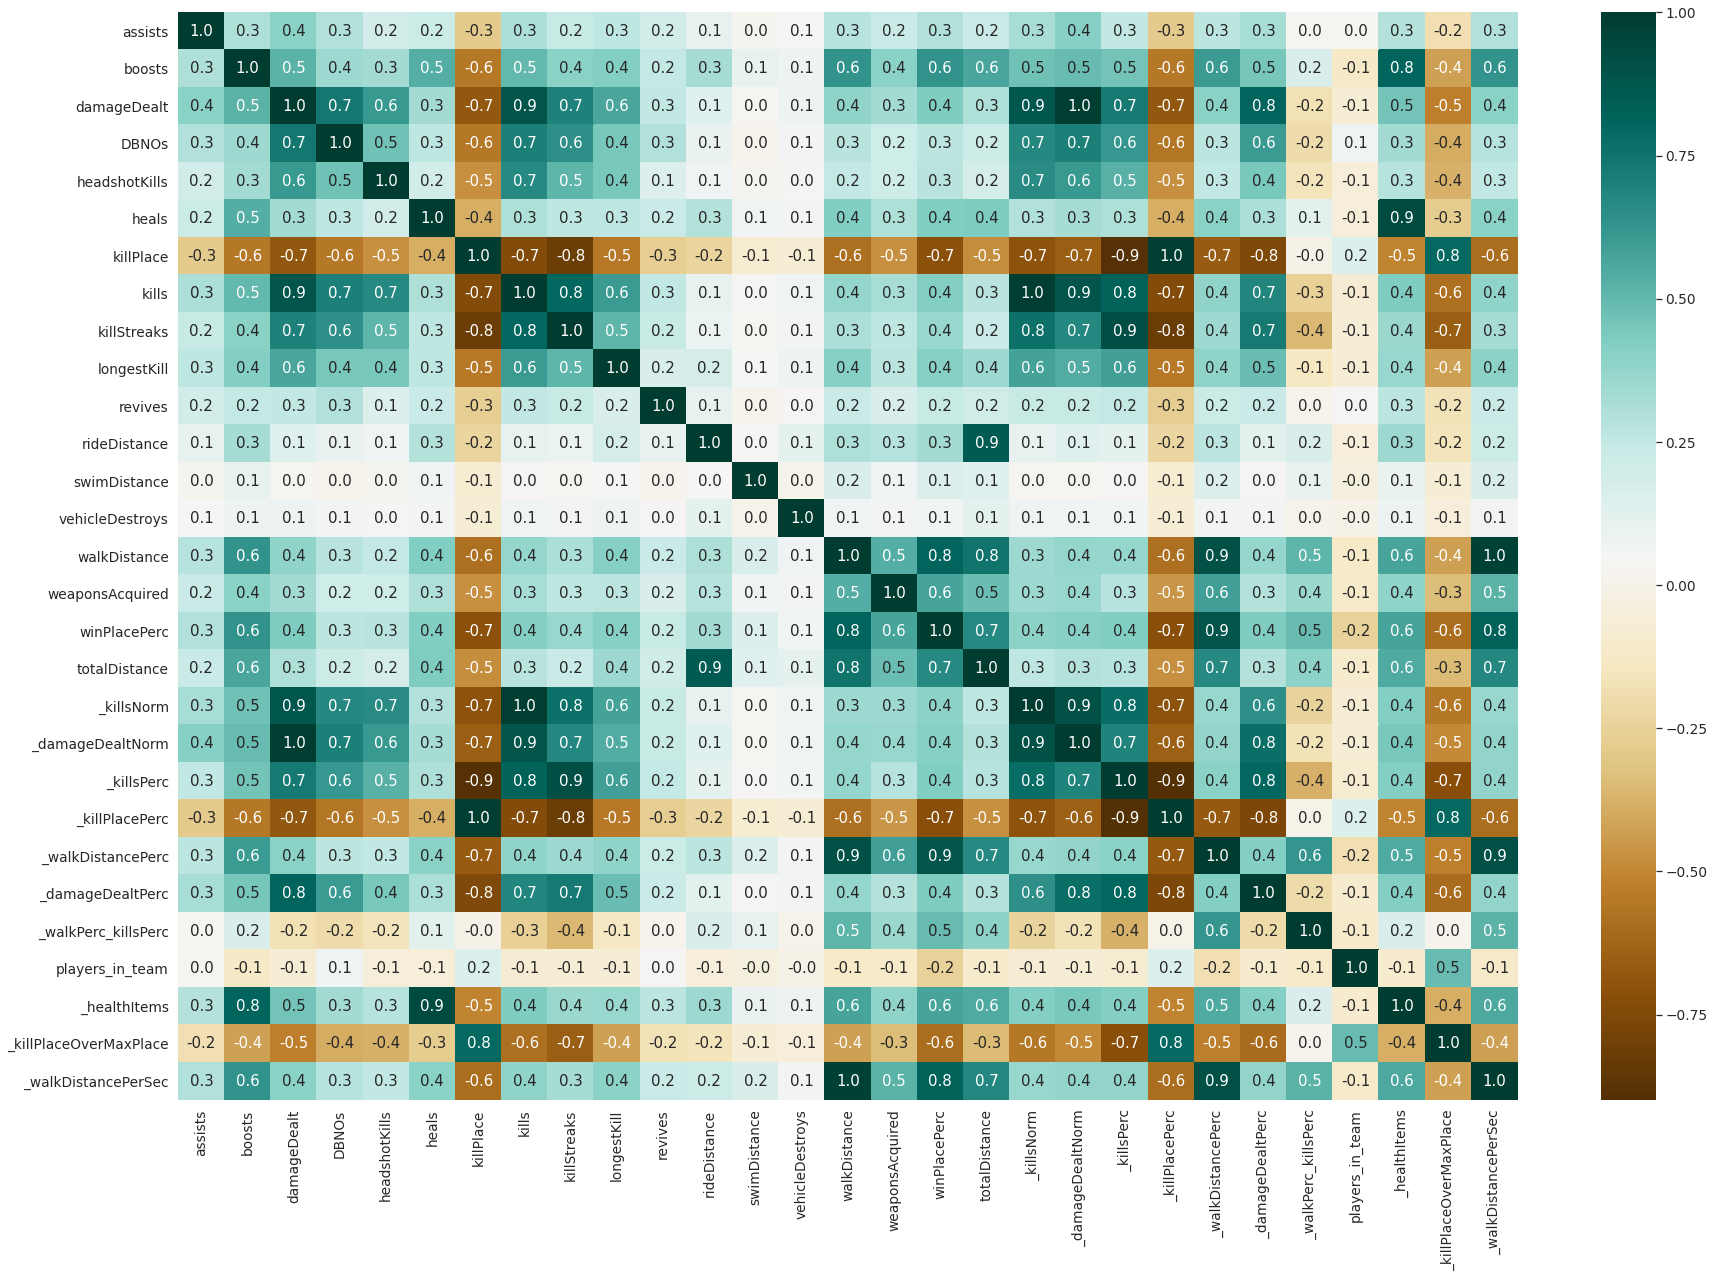

In [ ]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr, annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

In [ ]:
#saving highly correlated data
cleaned_data.to_csv('/content/drive/My Drive/PUBG/Highly_correlated_data.csv', index=False)

#**FINAL PREDICTION**

In [ ]:
highly_corr = pd.read_csv('/content/drive/My Drive/PUBG/Highly_correlated_data.csv')
highly_corr = reduce_mem_usage(highly_corr)

Memory usage of dataframe is 1055.71 MB --> 435.88 MB (Decreased by 58.7%)


In [ ]:
highly_corr.shape

(4193153, 33)

In [ ]:
X_train = highly_corr[highly_corr['winPlacePerc'].notnull()].reset_index(drop=True)
X_test = highly_corr[highly_corr['winPlacePerc'].isnull()].drop(['winPlacePerc'], axis=1).reset_index(drop=True)


Y_train = X_train.pop('winPlacePerc')
X_test_grp = X_test[['matchId','groupId']].copy()
train_matchId = X_train['matchId']

# drop matchId,groupId
X_train.drop(['matchId','groupId','Id'], axis=1, inplace=True)
X_test.drop(['matchId','groupId','Id'], axis=1, inplace=True)

print(X_train.shape, X_test.shape)

(4193153, 29) (0, 29)


In [ ]:
print('There are {} different Match types in the dataset.'.format(highly_corr['matchType'].nunique()))

There are 16 different Match types in the dataset.


In [ ]:
# One hot encode matchType
highly_corr = pd.get_dummies(highly_corr, columns=['matchType'])

#encoding
matchType_encoding = highly_corr.filter(regex='matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Turn groupId and match Id into categorical types
highly_corr['groupId'] = highly_corr['groupId'].astype('category')
highly_corr['matchId'] = highly_corr['matchId'].astype('category')

# Get category coding for groupId and matchID
highly_corr['groupId_cat'] = highly_corr['groupId'].cat.codes
highly_corr['matchId_cat'] = highly_corr['matchId'].cat.codes

# Get rid of old columns
highly_corr.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
highly_corr[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,597499,29974
1,805918,32632
2,821212,3131
3,1305033,45100
4,1711412,20453


In [ ]:
highly_corr.drop(columns = ['Id'], inplace=True)

Getting prepared for Machine Learning

In [ ]:
sample = 500000
df_sample = highly_corr.sample(sample)

In [ ]:

df = df_sample.drop(columns = ['winPlacePerc'])
y = df_sample['winPlacePerc'] 

In [ ]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 46) Sample target shape:  (440000,) Sample validation shape:  (60000, 46)


*Defining function for calculating Mean Absolute Error (MAE)*

In [ ]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
# Function to print the MAE (Mean Absolute Error) score
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    #Score of the training dataset obtained using an out-of-bag estimate.
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

*Creating a basic Random Forest Model*

In [ ]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.03314887391226297, 'mae val: ', 0.053762402137163164]


***Finding Feature Importance using Random Forest***

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [ ]:
# What are the most predictive features according to our basic random forest model
fi = rf_feat_importance(m1, df); fi[:15]

,cols,imp
14,walkDistance,0.159618
27,_walkDistancePerSec,0.158145
21,_walkDistancePerc,0.132270
20,_killPlacePerc,0.101902
16,totalDistance,0.078479
6,killPlace,0.060021
1,boosts,0.053530
25,_healthItems,0.039936
15,weaponsAcquired,0.037815
26,_killPlaceOverMaxPlace,0.037333


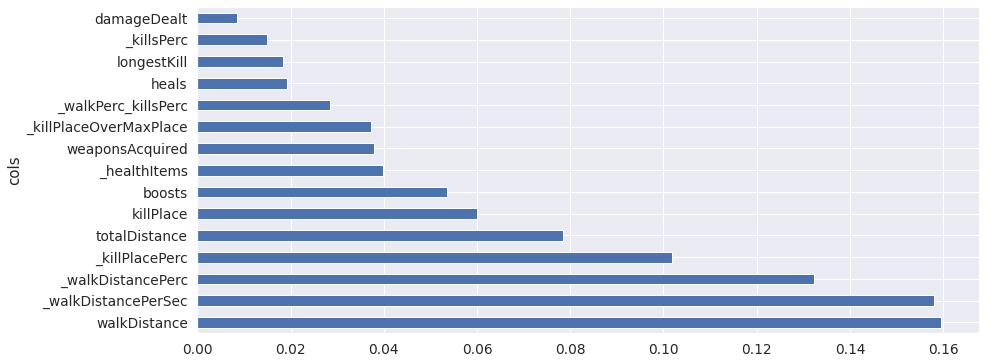

In [ ]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:15].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

In [ ]:
X_train.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'totalDistance', '_killsNorm', '_damageDealtNorm',
       '_killsPerc', '_killPlacePerc', '_walkDistancePerc', '_damageDealtPerc',
       '_walkPerc_killsPerc', 'players_in_team', '_healthItems',
       '_killPlaceOverMaxPlace', '_walkDistancePerSec', 'matchType_crashfpp',
       'matchType_crashtpp', 'matchType_duo', 'matchType_duo-fpp',
       'matchType_flarefpp', 'matchType_flaretpp', 'matchType_normal-duo',
       'matchType_normal-duo-fpp', 'matchType_normal-solo',
       'matchType_normal-solo-fpp', 'matchType_normal-squad',
       'matchType_normal-squad-fpp', 'matchType_solo', 'matchType_solo-fpp',
       'matchType_squad', 'matchType_squad-fpp', 'groupId_cat', 'matchId_cat'],
      dtype='object')

In [ ]:
print(X_train.shape, y_train.shape)

(440000, 46) (440000,)


In [ ]:
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  18


14              walkDistance
27       _walkDistancePerSec
21         _walkDistancePerc
20            _killPlacePerc
16             totalDistance
6                  killPlace
1                     boosts
25              _healthItems
15           weaponsAcquired
26    _killPlaceOverMaxPlace
23       _walkPerc_killsPerc
5                      heals
9                longestKill
19                _killsPerc
2                damageDealt
24           players_in_team
11              rideDistance
17                _killsNorm
Name: cols, dtype: object

In [ ]:
#  DataFrame with only significant features
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

*Building a Model with top features*

In [ ]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train: ', 0.030172827123910798, 'mae val: ', 0.051342249191084176]


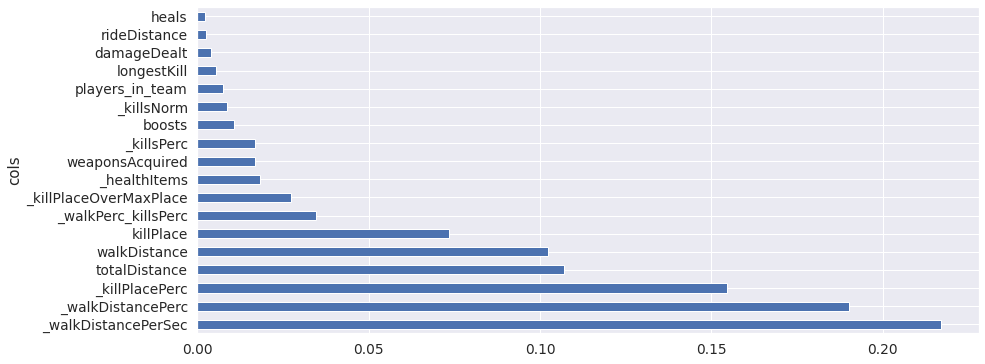

In [ ]:
#top feature importance
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

[]

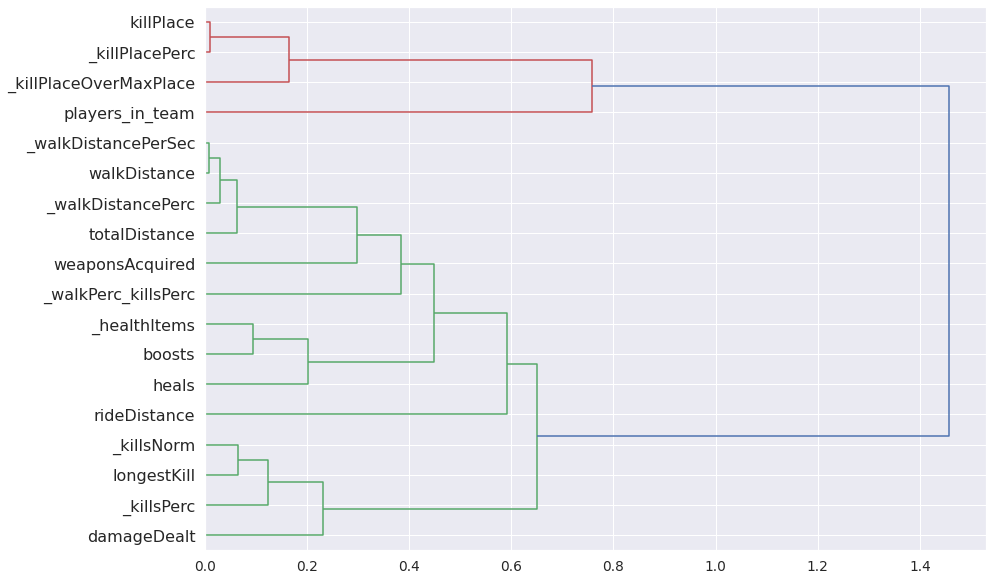

In [ ]:
import scipy
from scipy.cluster import hierarchy as hc
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='right', leaf_font_size=16)
plt.plot()

In [ ]:
# Defining a function get_sample to get random sample of n rows from dataframe(df), without replacement.
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [ ]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 1.7MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=13ca81c4f1de3a78cbff423d307b059a538af2b80e3cf325290f993309579362
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [ ]:
!pip install pandas_summary

In [ ]:
!pip install plotnine

In [ ]:
df_keep.head()

,walkDistance,_walkDistancePerSec,_walkDistancePerc,_killPlacePerc,totalDistance,killPlace,boosts,_healthItems,weaponsAcquired,_killPlaceOverMaxPlace,_walkPerc_killsPerc,heals,longestKill,_killsPerc,damageDealt,players_in_team,rideDistance,_killsNorm
2936928,1535.000000,1.109906,0.706522,0.195652,3420.462891,18,1,11,8,0.367347,0.860927,10,0.00,0.820652,447.500000,2,1883.0,2.16
2240112,3107.000000,1.638713,0.853933,0.280899,4760.000000,25,3,5,10,0.520833,1.310345,2,10.97,0.651685,102.300003,2,1653.0,1.11
3415563,931.299988,0.683774,0.483516,0.593407,931.299988,55,0,0,3,1.833333,1.725490,0,0.00,0.280220,25.900000,3,0.0,0.00
3336281,1571.000000,0.850108,0.677419,0.645161,3409.207031,62,0,0,3,1.265306,2.377358,0,0.00,0.284946,0.000000,2,1832.0,0.00
1674613,20.510000,0.014454,0.093750,1.000000,20.510000,100,0,0,0,1.000000,0.360000,0,0.00,0.260417,0.000000,1,0.0,0.00


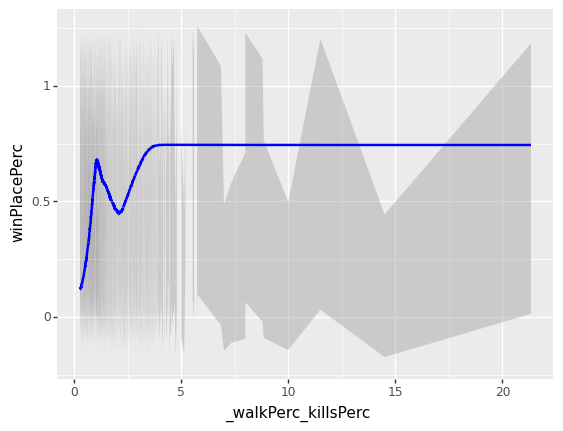

<ggplot: (-9223363274387291213)>

In [ ]:
# Plot the predictive quality of kills 
from pdpbox import pdp
from plotnine import *
from pandas_summary import DataFrameSummary
x_all = get_sample(highly_corr, 100000)
ggplot(x_all, aes('_walkPerc_killsPerc','winPlacePerc'))+stat_smooth(se=True, colour='blue', method='mavg')

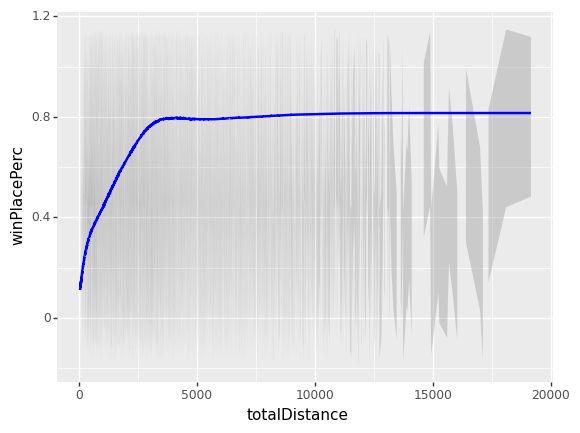

<ggplot: (8762467484634)>

In [ ]:
# Plot the predictive quality of walkDistance
x_all = get_sample(highly_corr, 100000)
ggplot(x_all, aes('totalDistance','winPlacePerc'))+stat_smooth(se=True, colour='blue', method='mavg')

In [ ]:
# Prepare data
train = highly_corr.copy()
val_perc_full = 0.20
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc'])
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (3354523, 18) Sample target shape:  (3354523,) Sample validation shape:  (838630, 18)


In [ ]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
#df.fillna(df.mean())
X_train = X_train.fillna(X_train.mean())
y_train = y_train.fillna(y_train.mean())
m3 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)